# A. Offline Noise Removal
## 1. Line Noise Removal

* <b>CleanLineNoise</b> removes the line frequency (50 or 60 Hz) and harmonics that are multiples of the line frequency up to the Nyquist frequency.
    

In [1]:
import numpy as np
import ln_removal
import plotting

# a. Reading in our ExG signal
## i. Tapping artifact
ExG_tap = np.transpose( np.genfromtxt("ExG_data/offline_exp_ExG-30s.csv", delimiter = ',') )
ExG_tap = ExG_tap[:, 1:]
# timestamps start at 0 s
ExG_tap[0] = ExG_tap[0] - ExG_tap[0][0]

## ii. Blinking artifact
ExG_blink = np.transpose( np.genfromtxt("ExG_data/blinking-artifact_ExG.csv", delimiter = ',') )
ExG_blink = ExG_blink[:, 1:]
# timestamps start at 0 s
ExG_blink[0] = ExG_blink[0] - ExG_blink[0][0]

## iii. Movement artifact
ExG_mov = np.transpose( np.genfromtxt("ExG_data/movement-artifact_ExG.csv", delimiter = ',') )
ExG_mov = ExG_mov[:, 1:]
# timestamps start at 0 s
ExG_mov[0] = ExG_mov[0] - ExG_mov[0][0]

s_rate = 250 # Sampling rate = 250 Hz
ln_freq = 50 # Line frequency = 50 Hz


# b. Adding components at the line frequency + harmonics and frequencies > 100 Hz
## i. Noisy signal: Tapping artifact
dt_tap = ExG_tap[0][1] - ExG_tap[0][0]
t_tap = ExG_tap[0]
line_sig_tap = 20 * ( np.sin(2*np.pi*50*t_tap) + np.sin(2*np.pi*100*t_tap) + np.sin(2*np.pi*120*t_tap) )
ExG_tap_sig = ExG_tap
ExG_tap_sig[1:] = ExG_tap[1:] + line_sig_tap
## ii. Noisy signal: Blinking artifact
dt_blink = ExG_blink[0][1] - ExG_blink[0][0]
t_blink = ExG_blink[0]
line_sig_blink = 20 * ( np.sin(2*np.pi*50*t_blink) + np.sin(2*np.pi*100*t_blink) + np.sin(2*np.pi*120*t_blink) )
ExG_blink_sig = ExG_blink
ExG_blink_sig[1:] = ExG_blink[1:] + line_sig_blink
## iii. Noisy signal: Movement artifact
dt_mov = ExG_mov[0][1] - ExG_mov[0][0]
t_mov = ExG_mov[0]
line_sig_mov = 20 * ( np.sin(2*np.pi*50*t_mov) + np.sin(2*np.pi*100*t_mov) + np.sin(2*np.pi*120*t_mov) )
ExG_mov_sig = ExG_mov
ExG_mov_sig[1:] = ExG_mov[1:] + line_sig_mov


#       Computing Fourier Transform
## i. Noisy signal: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_sig] = plotting.compute_fft(t_tap, ExG_tap_sig[1])
## ii. Noisy signal: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_sig] = plotting.compute_fft(t_blink, ExG_blink_sig[1])
## iii. Noisy signal: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_sig] = plotting.compute_fft(t_mov, ExG_mov_sig[1]) 


# c. Removing the line noise
## i. LN removed: Tapping artifact
ExG_tap_lnrm = ln_removal.clean_ln_ch(ExG_tap_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_tap_lnrm)] )

## ii. LN removed: Blinking artifact
ExG_blink_lnrm = ln_removal.clean_ln_ch(ExG_blink_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_blink_lnrm)] )

## iii. LN removed: Movement artifact
ExG_mov_lnrm = ln_removal.clean_ln_ch(ExG_mov_sig[1, :], ln_freq, s_rate)
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_lnrm = np.transpose( np.c_[tmp, np.transpose(ExG_mov_lnrm)] )


#       Computing Fourier Transform
## i. LN removed: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_lnrm] = plotting.compute_fft(t_tap, ExG_tap_lnrm[1])
## ii. LN removed: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_lnrm] = plotting.compute_fft(t_blink, ExG_blink_lnrm[1])
## iii. LN removed: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_lnrm] = plotting.compute_fft(t_mov, ExG_mov_lnrm[1])


Removed notch frequencies (Hz):
     50.00 :   14 windows
    100.00 :   14 windows
Removed notch frequencies (Hz):
     50.00 :   13 windows
    100.00 :   13 windows
Removed notch frequencies (Hz):
     50.00 :   13 windows
    100.00 :   13 windows


#### (i) Tapping Artifact

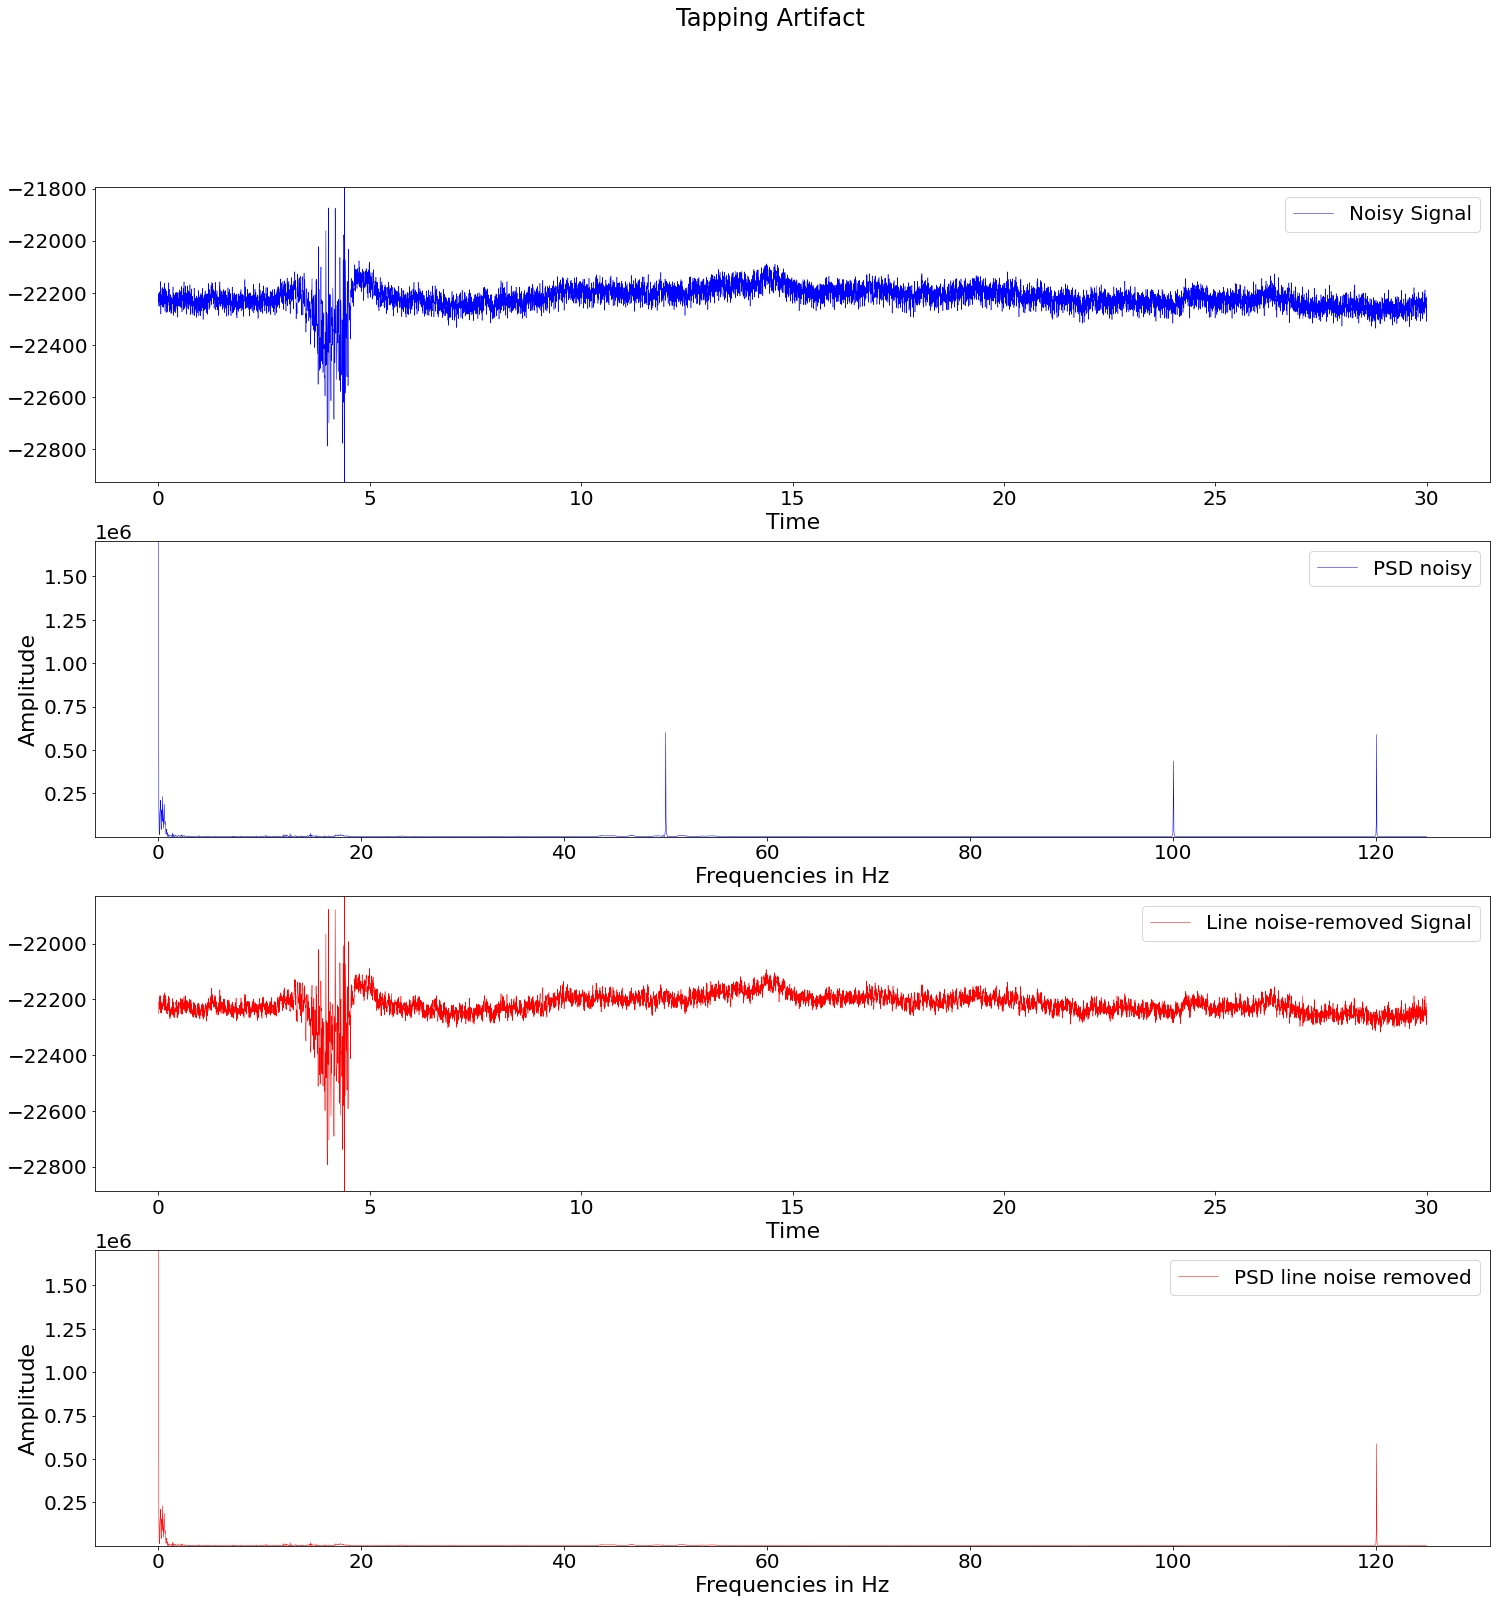

In [3]:
import matplotlib.pyplot as plt
import plotting

plt.rcParams['figure.figsize'] = [25, 25]
# d. Plotting the spectrum before and after the Line noise removal
plotting.subplot(4, 1, 'Tapping Artifact', 
                        x_axes=[t_tap, freq_tap[idxs_half_tap], t_tap, freq_tap[idxs_half_tap]],
                        y_axes=[ExG_tap_sig[1], np.abs(psd_tap_sig[idxs_half_tap]), ExG_tap_lnrm[1], np.abs(psd_tap_lnrm[idxs_half_tap])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Noisy Signal', 'PSD noisy', 'Line noise-removed Signal', 'PSD line noise removed'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (ii) Blinking Artifact

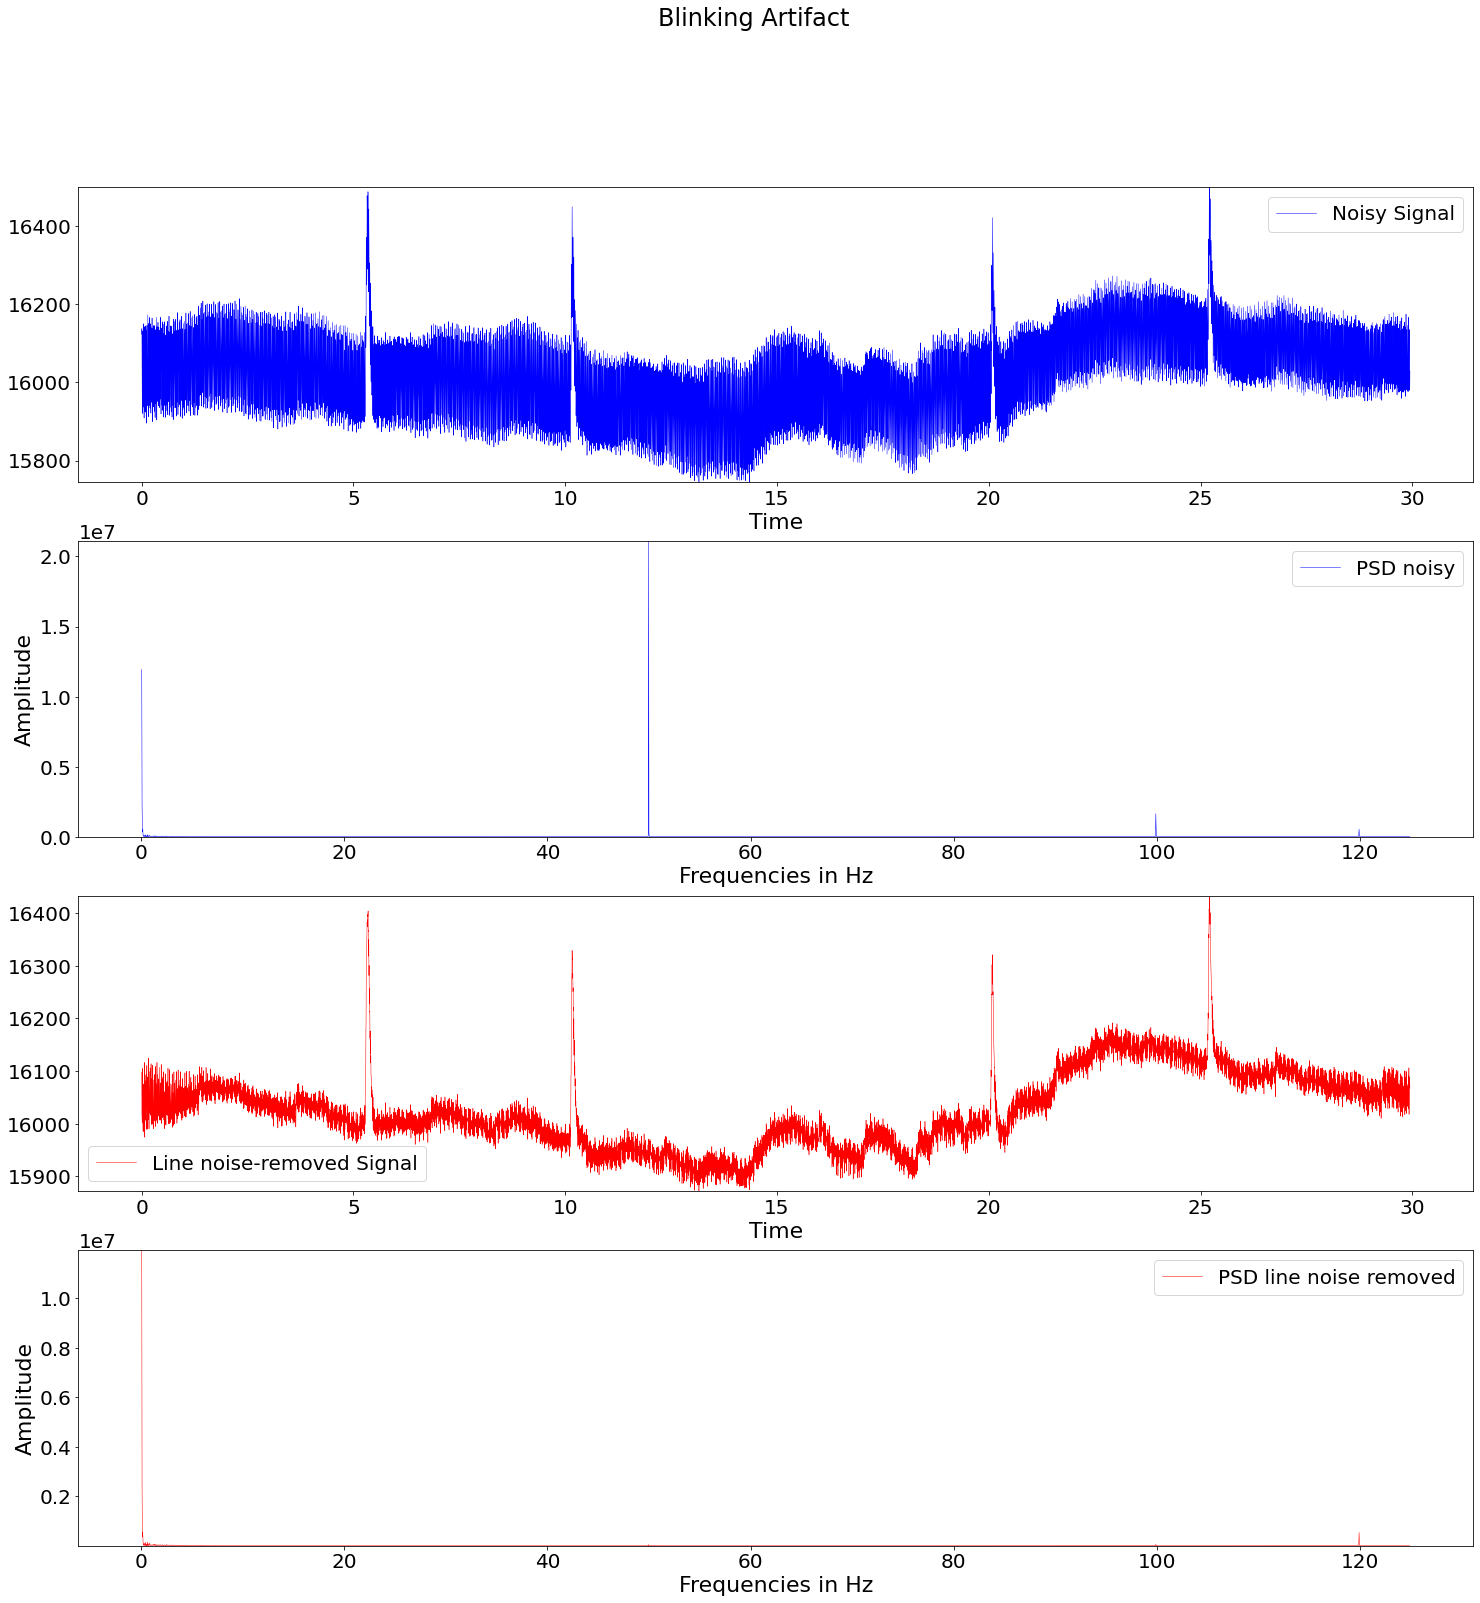

In [5]:
# d. Plotting the spectrum before and after the Line noise removal
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Blinking Artifact', 
                        x_axes=[t_blink, freq_blink[idxs_half_blink], t_blink, freq_blink[idxs_half_blink]],
                        y_axes=[ExG_blink_sig[1], np.abs(psd_blink_sig[idxs_half_blink]), ExG_blink_lnrm[1], np.abs(psd_blink_lnrm[idxs_half_blink])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Noisy Signal', 'PSD noisy', 'Line noise-removed Signal', 'PSD line noise removed'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (iii) Movement Artifact

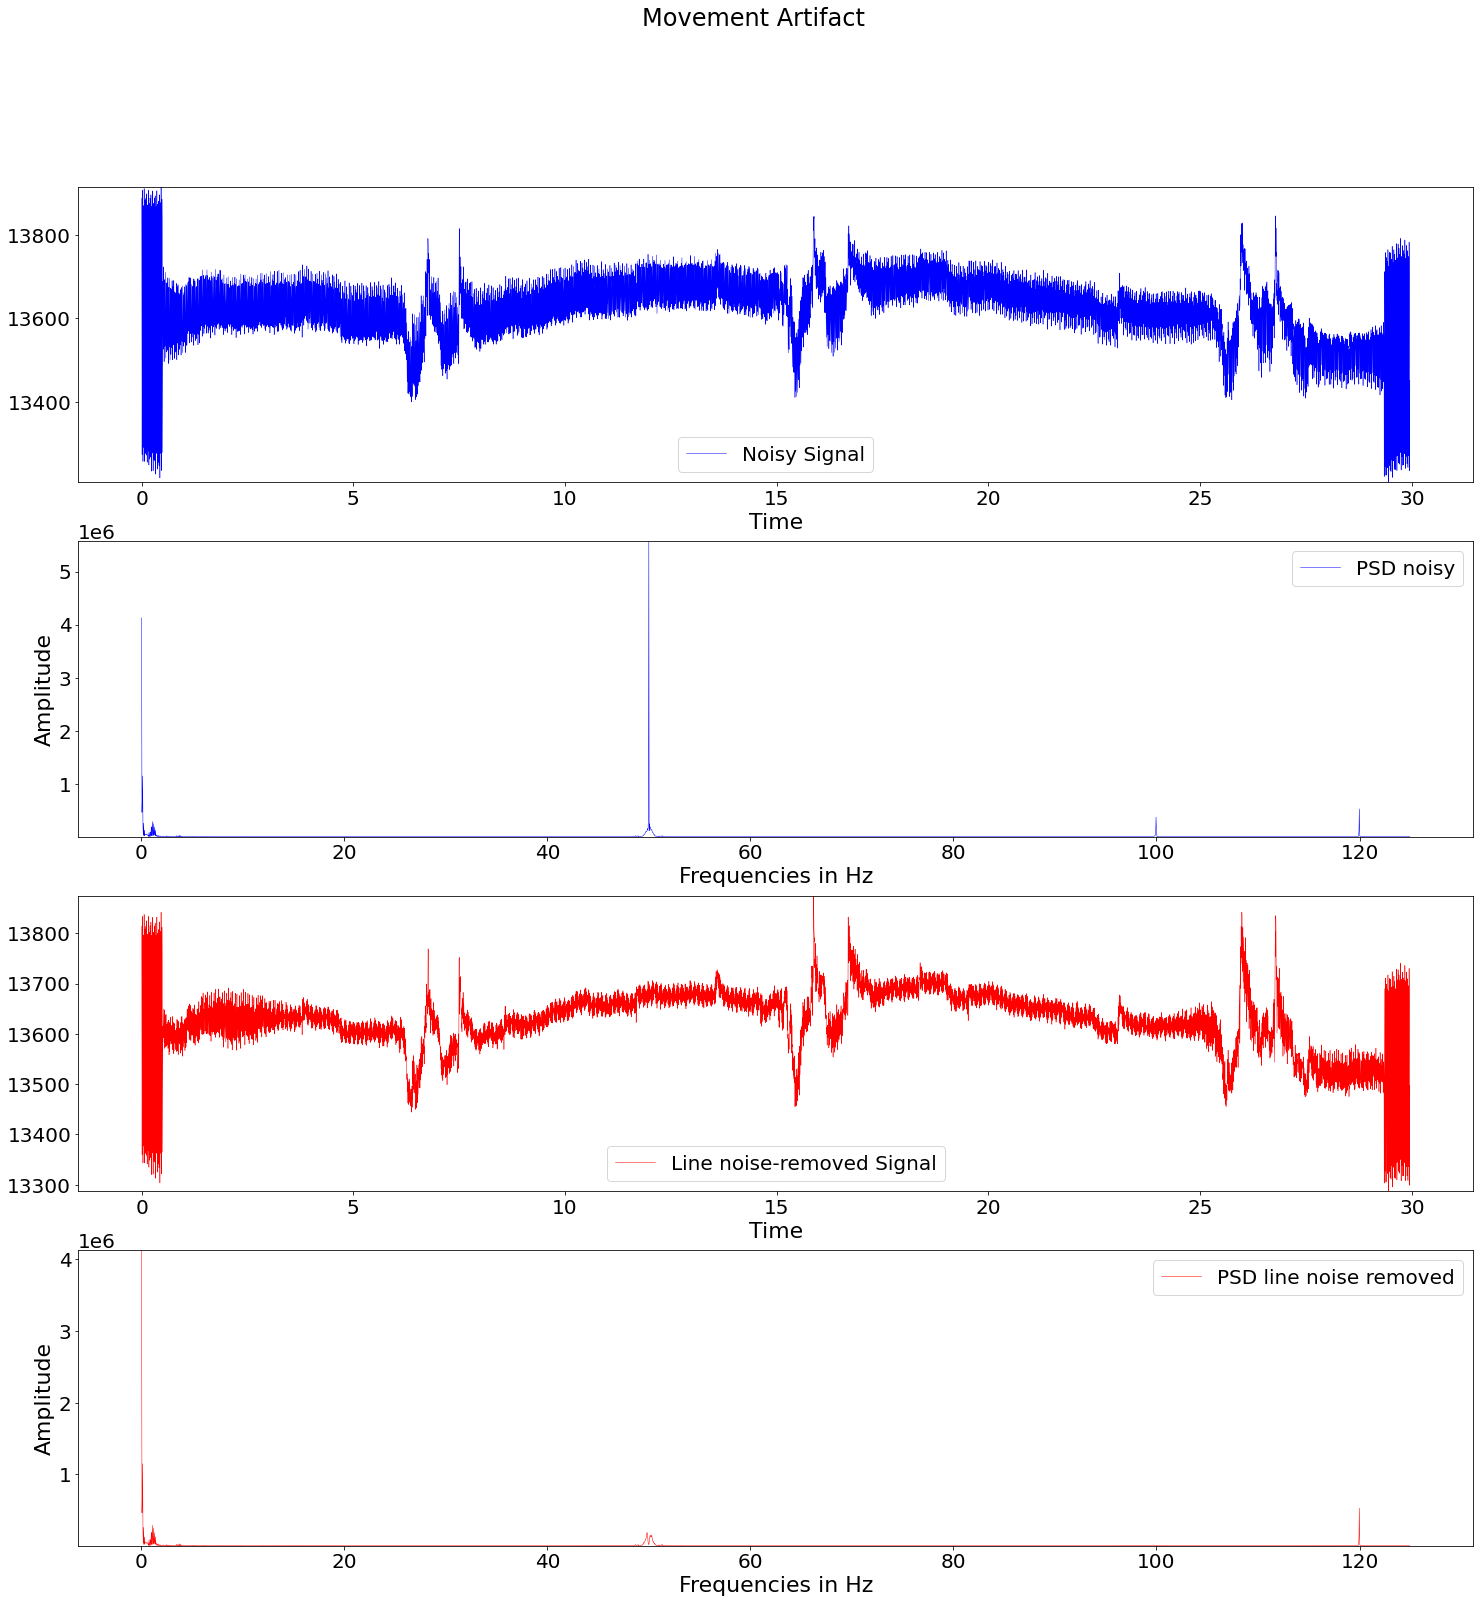

In [6]:
# d. Plotting the spectrum before and after the Line noise removal
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Movement Artifact', 
                        x_axes=[t_mov, freq_mov[idxs_half_mov], t_mov, freq_mov[idxs_half_mov]],
                        y_axes=[ExG_mov_sig[1], np.abs(psd_mov_sig[idxs_half_mov]), ExG_mov_lnrm[1], np.abs(psd_mov_lnrm[idxs_half_mov])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Noisy Signal', 'PSD noisy', 'Line noise-removed Signal', 'PSD line noise removed'],
                        plot_colors=['b', 'b', 'r', 'r'])

## 2. Filtering
* Applying a lowpass filter at frequency 100 Hz

In [7]:
import filtering

# a. Filtering signal
## i. Filtered: Tapping artifact
ExG_tap_lpf = filtering.lp_filt_ch(ExG_tap_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_tap_lpf)] )

## ii. Filtered: Blinking artifact
ExG_blink_lpf = filtering.lp_filt_ch(ExG_blink_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_blink_lpf)] )

## iii. Filtered: Movement artifact
ExG_mov_lpf = filtering.lp_filt_ch(ExG_mov_lnrm[1, :], s_rate=s_rate)
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_lpf = np.transpose( np.c_[tmp, np.transpose(ExG_mov_lpf)] )


#       Computing Fourier Transform
## i. Filtered: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_lpf] = plotting.compute_fft(t_tap, ExG_tap_lpf[1])
## ii. Filtered: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_lpf] = plotting.compute_fft(t_blink, ExG_blink_lpf[1])
## iii. Filtered: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_lpf] = plotting.compute_fft(t_mov, ExG_mov_lpf[1])


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)

Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain 

#### (i) Tapping Artifact

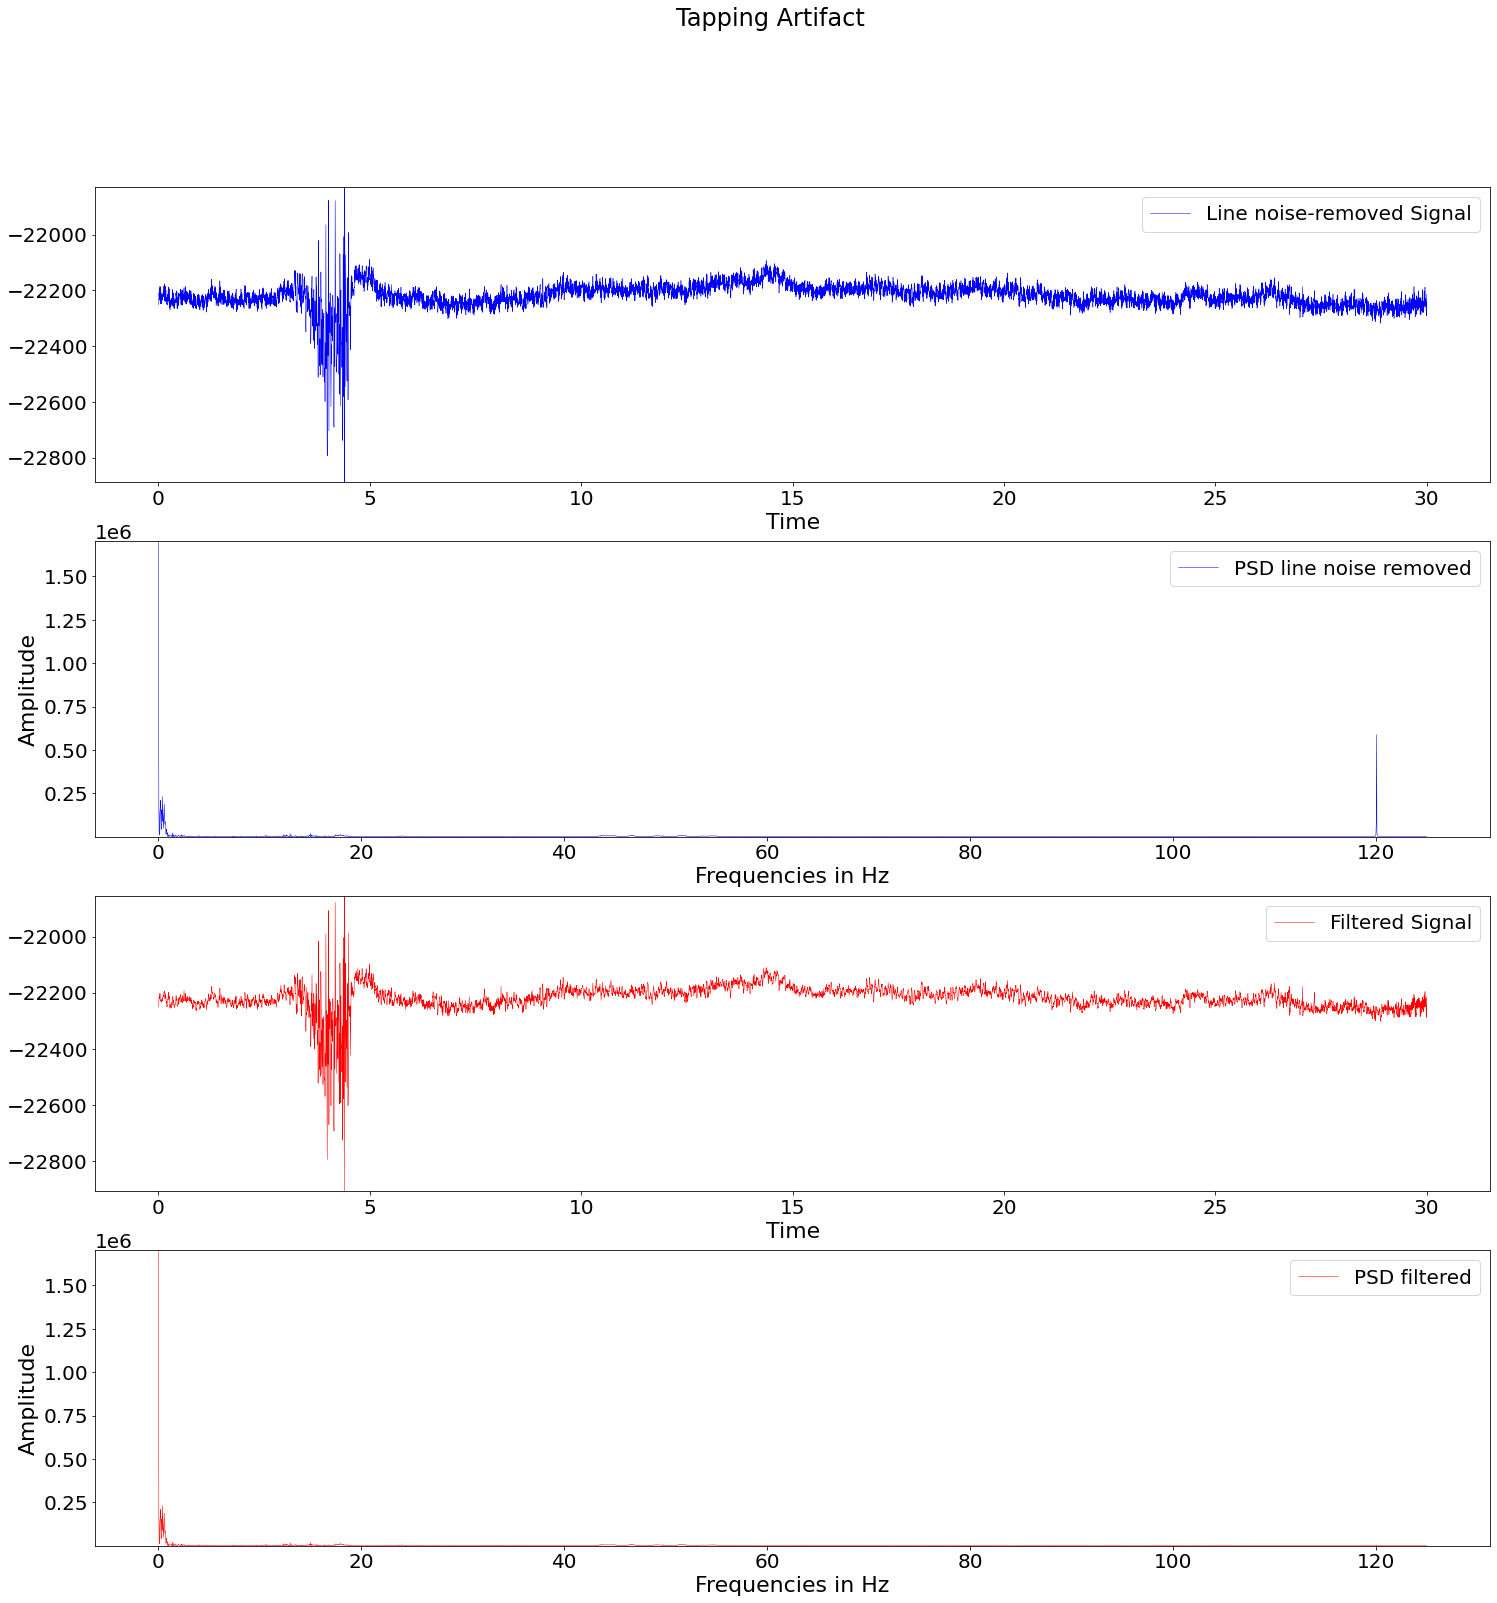

In [8]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Tapping Artifact', 
                        x_axes=[t_tap, freq_tap[idxs_half_tap], t_tap, freq_tap[idxs_half_tap]],
                        y_axes=[ExG_tap_lnrm[1], np.abs(psd_tap_lnrm[idxs_half_tap]), ExG_tap_lpf[1], np.abs(psd_tap_lpf[idxs_half_tap])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Line noise-removed Signal', 'PSD line noise removed', 'Filtered Signal', 'PSD filtered'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (ii) Blinking Artifact

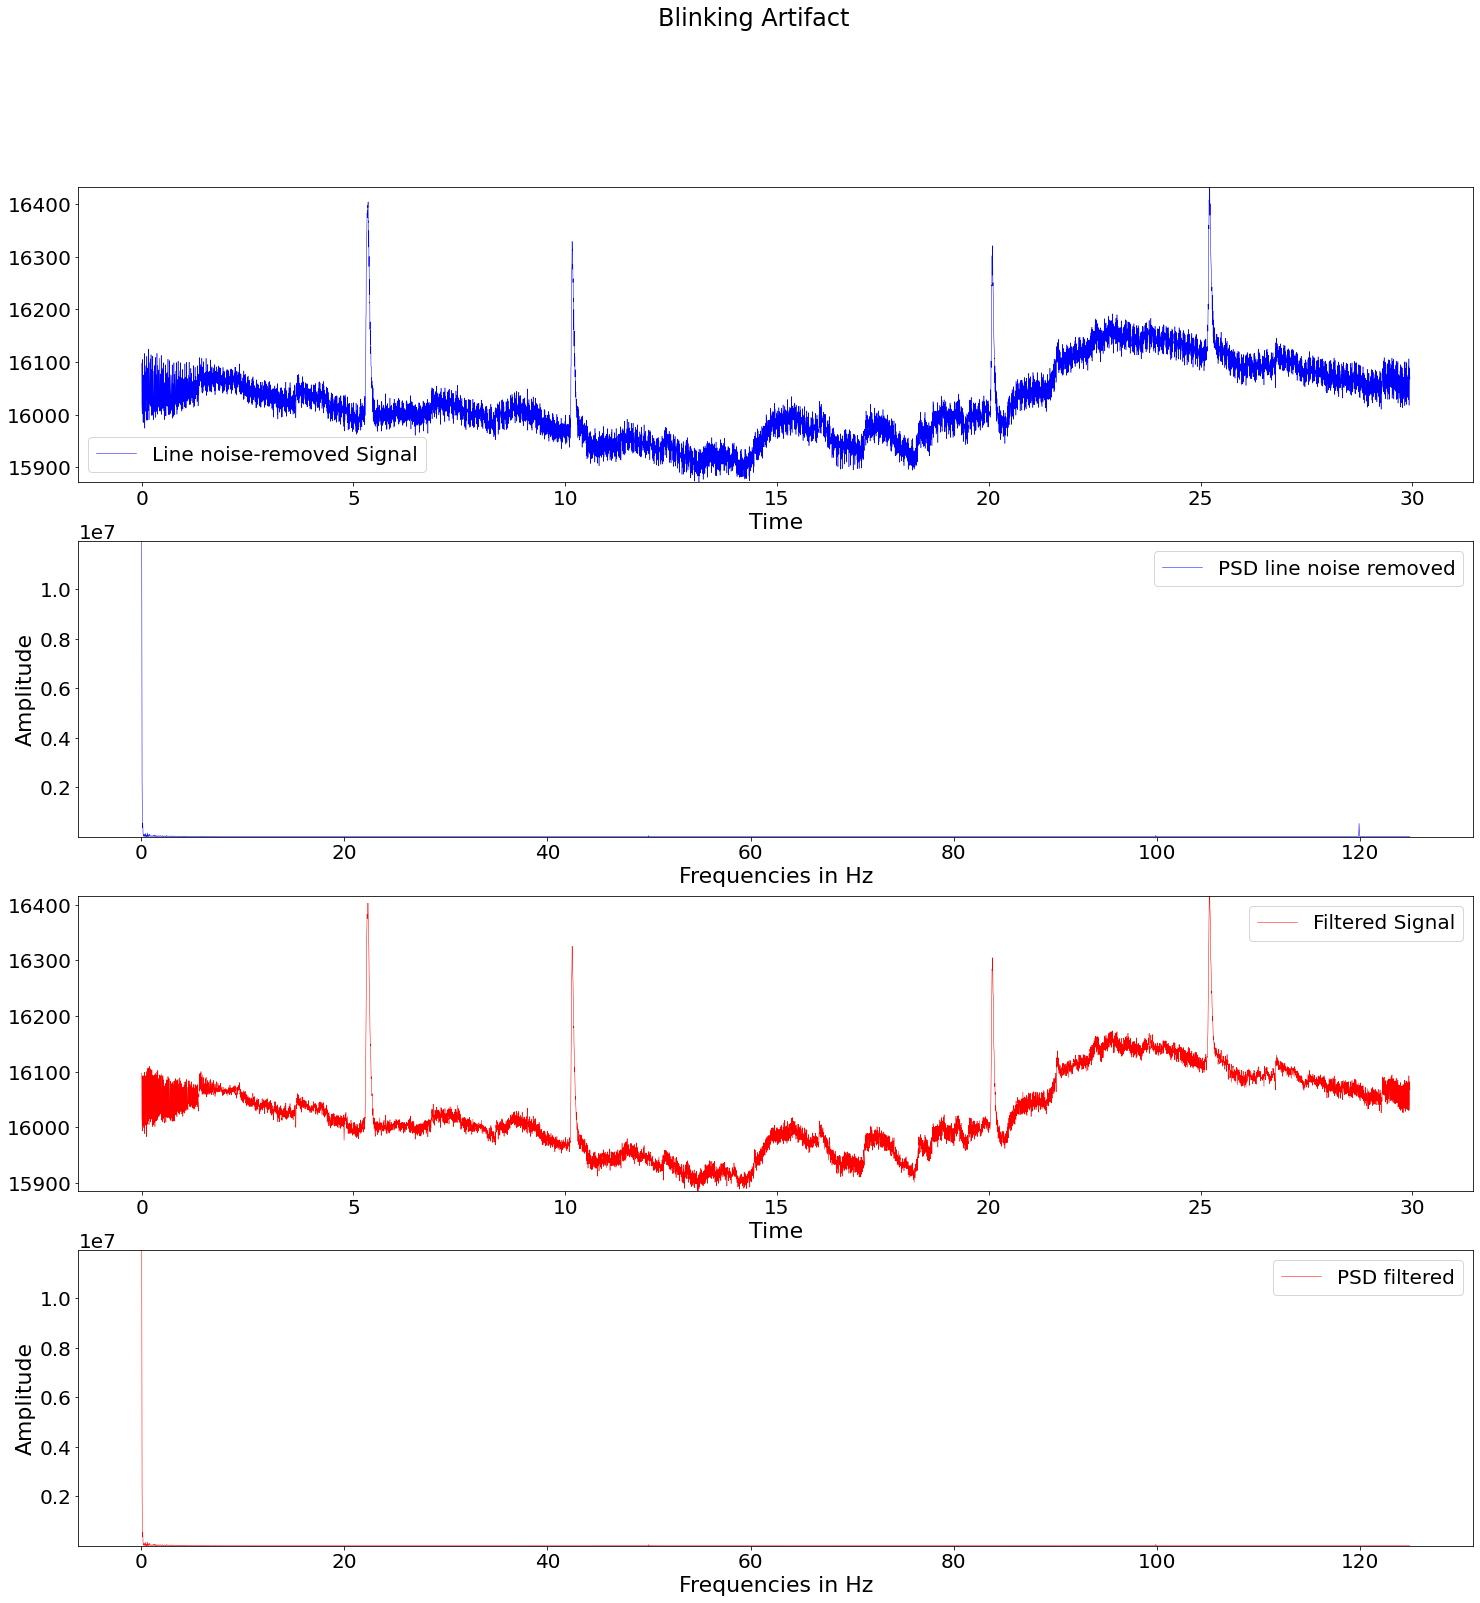

In [9]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Blinking Artifact', 
                        x_axes=[t_blink, freq_blink[idxs_half_blink], t_blink, freq_blink[idxs_half_blink]],
                        y_axes=[ExG_blink_lnrm[1], np.abs(psd_blink_lnrm[idxs_half_blink]), ExG_blink_lpf[1], np.abs(psd_blink_lpf[idxs_half_blink])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Line noise-removed Signal', 'PSD line noise removed', 'Filtered Signal', 'PSD filtered'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (iii) Movement Artifact

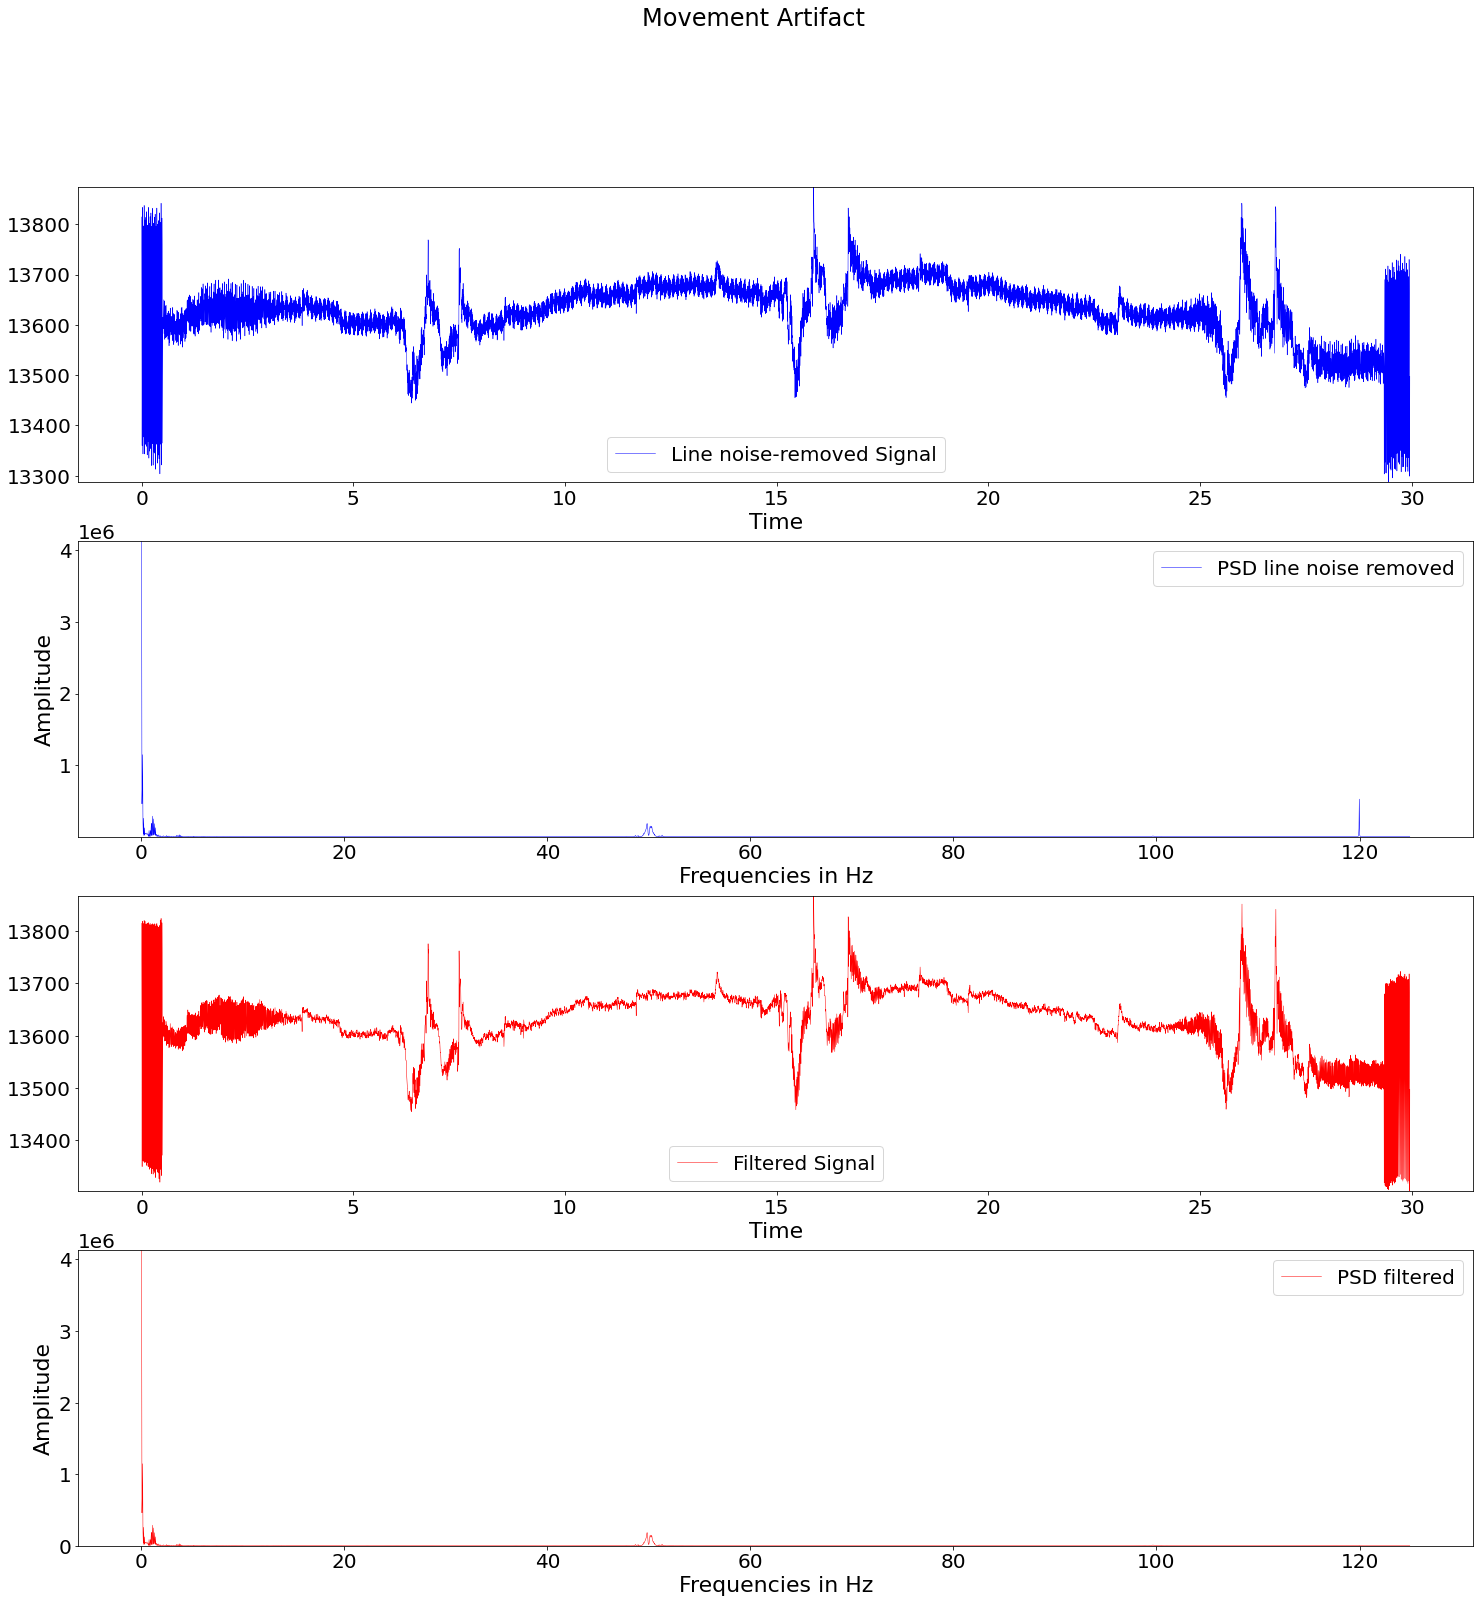

In [10]:
# b. Plotting the spectrum before and after Filtering
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Movement Artifact', 
                        x_axes=[t_mov, freq_mov[idxs_half_mov], t_mov, freq_mov[idxs_half_mov]],
                        y_axes=[ExG_mov_lnrm[1], np.abs(psd_mov_lnrm[idxs_half_mov]), ExG_mov_lpf[1], np.abs(psd_mov_lpf[idxs_half_mov])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Line noise-removed Signal', 'PSD line noise removed', 'Filtered Signal', 'PSD filtered'],
                        plot_colors=['b', 'b', 'r', 'r'])

In [11]:
# Exporting filtered signal to process on MATLAB
## i. Tapping Artifact
np.savetxt('ExG_data/ExG_tap_lpf.csv', np.transpose(ExG_tap_lpf[1]), delimiter=",")
## ii. Blinking Artifact
np.savetxt('ExG_data/ExG_blink_lpf.csv', np.transpose(ExG_blink_lpf[1]), delimiter=",")
## iii. Movement Artifact
np.savetxt('ExG_data/ExG_mov_lpf.csv', np.transpose(ExG_mov_lpf[1]), delimiter=",")

## 3. Wavelet Thresholding
1. Wavelet Transform  
    * Each electrode’s time series is subjected to wavelet transform.
    * Chosen wavelet function: Coiflet order 4 (`coif4`)
    * Level of Data Decomposition:
        * if sampling rate > 500 Hz = `10`
        * if 250 Hz < sampling rate <= 500 Hz = `9`
        * if sampling rate <= 250 Hz = `8`
2. Determining threshold values for each level
    * Wavelet coefficients are then subjected to thresholding (in a `level-dependent` way)
    * The chosen method to determine these threshold values: `Bayes`   
    (I. M. Johnstone, B. W. Silverman (2005). [Empirical Bayes Selection of Wavelet Thresholds](https://arxiv.org/pdf/math/0508281.pdf)) 
3. Thresholding
    * Thresholding rule: `Hard`
4. Reconstruction
    * The resulting coefficients are reconstructed into a signal

### Bayes Thresholding

In [13]:
import numpy as np
import pywt
from wav_thd.ebayesthd_wav_dwt import ebayesthd_wav_dwt
import matplotlib.pyplot as plt 

# a. Wavelet Tresholding
## i. Denoised: Tapping artifact
#   Wavelet thresholding 
artifacts_tap = ebayesthd_wav_dwt(ExG_tap_lpf[1, :], s_rate)
#   Denoised signal
ExG_tap_bayes = ExG_tap_lpf[1, :] - artifacts_tap
#   include the timestamps
tmp = ExG_tap_sig[0, :]
ExG_tap_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_tap_bayes)] )

## ii. Denoised: Blinking artifact
#   Wavelet thresholding 
artifacts_blink = ebayesthd_wav_dwt(ExG_blink_lpf[1, :], s_rate)
#   Denoised signal
ExG_blink_bayes = ExG_blink_lpf[1, :] - artifacts_blink
#   include the timestamps
tmp = ExG_blink_sig[0, :]
ExG_blink_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_blink_bayes)] )

## iii. Denoised: Movement artifact
#   Wavelet thresholding 
artifacts_mov = ebayesthd_wav_dwt(ExG_mov_lpf[1, :], s_rate)
#   Denoised signal
ExG_mov_bayes = ExG_mov_lpf[1, :] - artifacts_mov
#   include the timestamps
tmp = ExG_mov_sig[0, :]
ExG_mov_bayes = np.transpose( np.c_[tmp, np.transpose(ExG_mov_bayes)] )


#       Computing Fourier Transform
## i. Denoised: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_bayes] = plotting.compute_fft(t_tap, ExG_tap_bayes[1])
## ii. Denoised: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_bayes] = plotting.compute_fft(t_blink, ExG_blink_bayes[1])
## iii. Denoised: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_bayes] = plotting.compute_fft(t_mov, ExG_mov_bayes[1])

Here, the acquired results are compared to the results of the original HAPPILEE pipeline in Matlab.

In [14]:
# Reading in results from MATLAB
ExG_tap_bayes_m = np.transpose( np.genfromtxt("ExG_data/ExG_tap_bayes_m.csv", delimiter = ',') )
ExG_blink_bayes_m = np.transpose( np.genfromtxt("ExG_data/ExG_blink_bayes_m.csv", delimiter = ',') )
ExG_mov_bayes_m = np.transpose( np.genfromtxt("ExG_data/ExG_mov_bayes_m.csv", delimiter = ',') )


#       Computing Fourier Transform
## i. Denoised on MATLAB: Tapping artifact
[freq_tap, idxs_half_tap, psd_tap_bayes_m] = plotting.compute_fft(t_tap, ExG_tap_bayes_m)
## ii. Denoised on MATLAB: Blinking artifact
[freq_blink, idxs_half_blink, psd_blink_bayes_m] = plotting.compute_fft(t_blink, ExG_blink_bayes_m)
## iii. Denoised on MATLAB: Movement artifact
[freq_mov, idxs_half_mov, psd_mov_bayes_m] = plotting.compute_fft(t_mov, ExG_mov_bayes_m)


# Comparing both results by normalized cross correlation
# i. Tapping artifact
ExG_tap_bayes_norm = (ExG_tap_bayes[1] - np.mean(ExG_tap_bayes[1])) / (np.std(ExG_tap_bayes[1]) * len(ExG_tap_bayes[1]))
ExG_tap_bayes_m_norm = (ExG_tap_bayes_m - np.mean(ExG_tap_bayes_m)) / (np.std(ExG_tap_bayes_m))
c_tap = np.correlate(ExG_tap_bayes_norm, ExG_tap_bayes_m_norm)
print("Normalized cross correlation (tapping artifact):", c_tap)

# ii. Blinking artifact
ExG_blink_bayes_norm = (ExG_blink_bayes[1] - np.mean(ExG_blink_bayes[1])) / (np.std(ExG_blink_bayes[1]) * len(ExG_blink_bayes[1]))
ExG_blink_bayes_m_norm = (ExG_blink_bayes_m - np.mean(ExG_blink_bayes_m)) / (np.std(ExG_blink_bayes_m))
c_blink = np.correlate(ExG_blink_bayes_norm, ExG_blink_bayes_m_norm)
print("Normalized cross correlation (blinking artifact):", c_blink)

# iii. Movement artifact
ExG_mov_bayes_norm = (ExG_mov_bayes[1] - np.mean(ExG_mov_bayes[1])) / (np.std(ExG_mov_bayes[1]) * len(ExG_mov_bayes[1]))
ExG_mov_bayes_m_norm = (ExG_mov_bayes_m - np.mean(ExG_mov_bayes_m)) / (np.std(ExG_mov_bayes_m))
c_mov = np.correlate(ExG_mov_bayes_norm, ExG_mov_bayes_m_norm)
print("Normalized cross correlation (movement artifact):", c_mov)

Normalized cross correlation (tapping artifact): [0.98771902]
Normalized cross correlation (blinking artifact): [0.99906128]
Normalized cross correlation (movement artifact): [0.99094951]


#### (i) Tapping Artifact

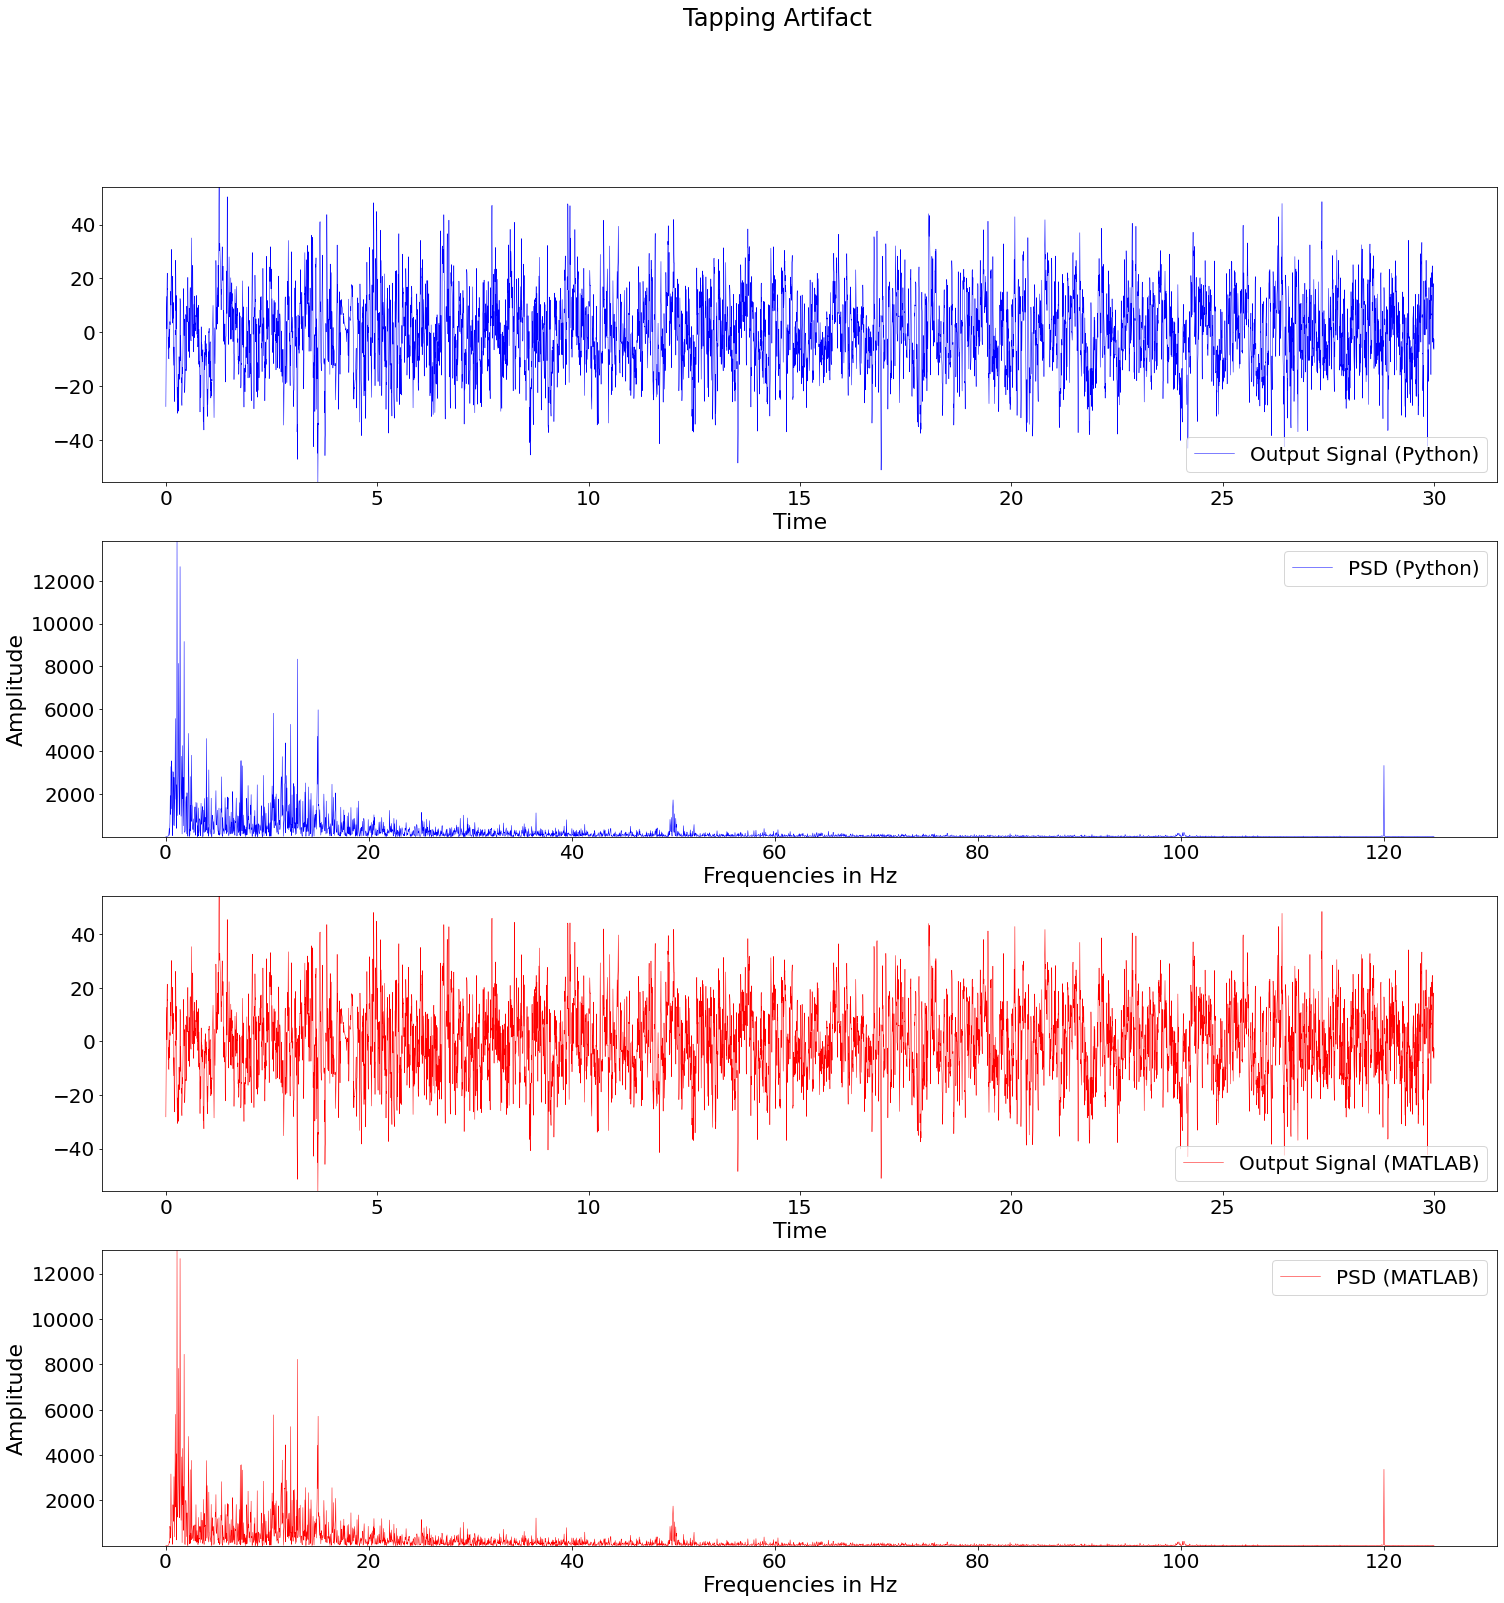

In [15]:
# Plotting both results
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Tapping Artifact', 
                        x_axes=[t_tap, freq_tap[idxs_half_tap], t_tap, freq_tap[idxs_half_tap]],
                        y_axes=[ExG_tap_bayes[1], np.abs(psd_tap_bayes[idxs_half_tap]), ExG_tap_bayes_m,np.abs(psd_tap_bayes_m[idxs_half_tap])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Output Signal (Python)', 'PSD (Python)', 'Output Signal (MATLAB)', 'PSD (MATLAB)'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (ii) Blinking Artifact

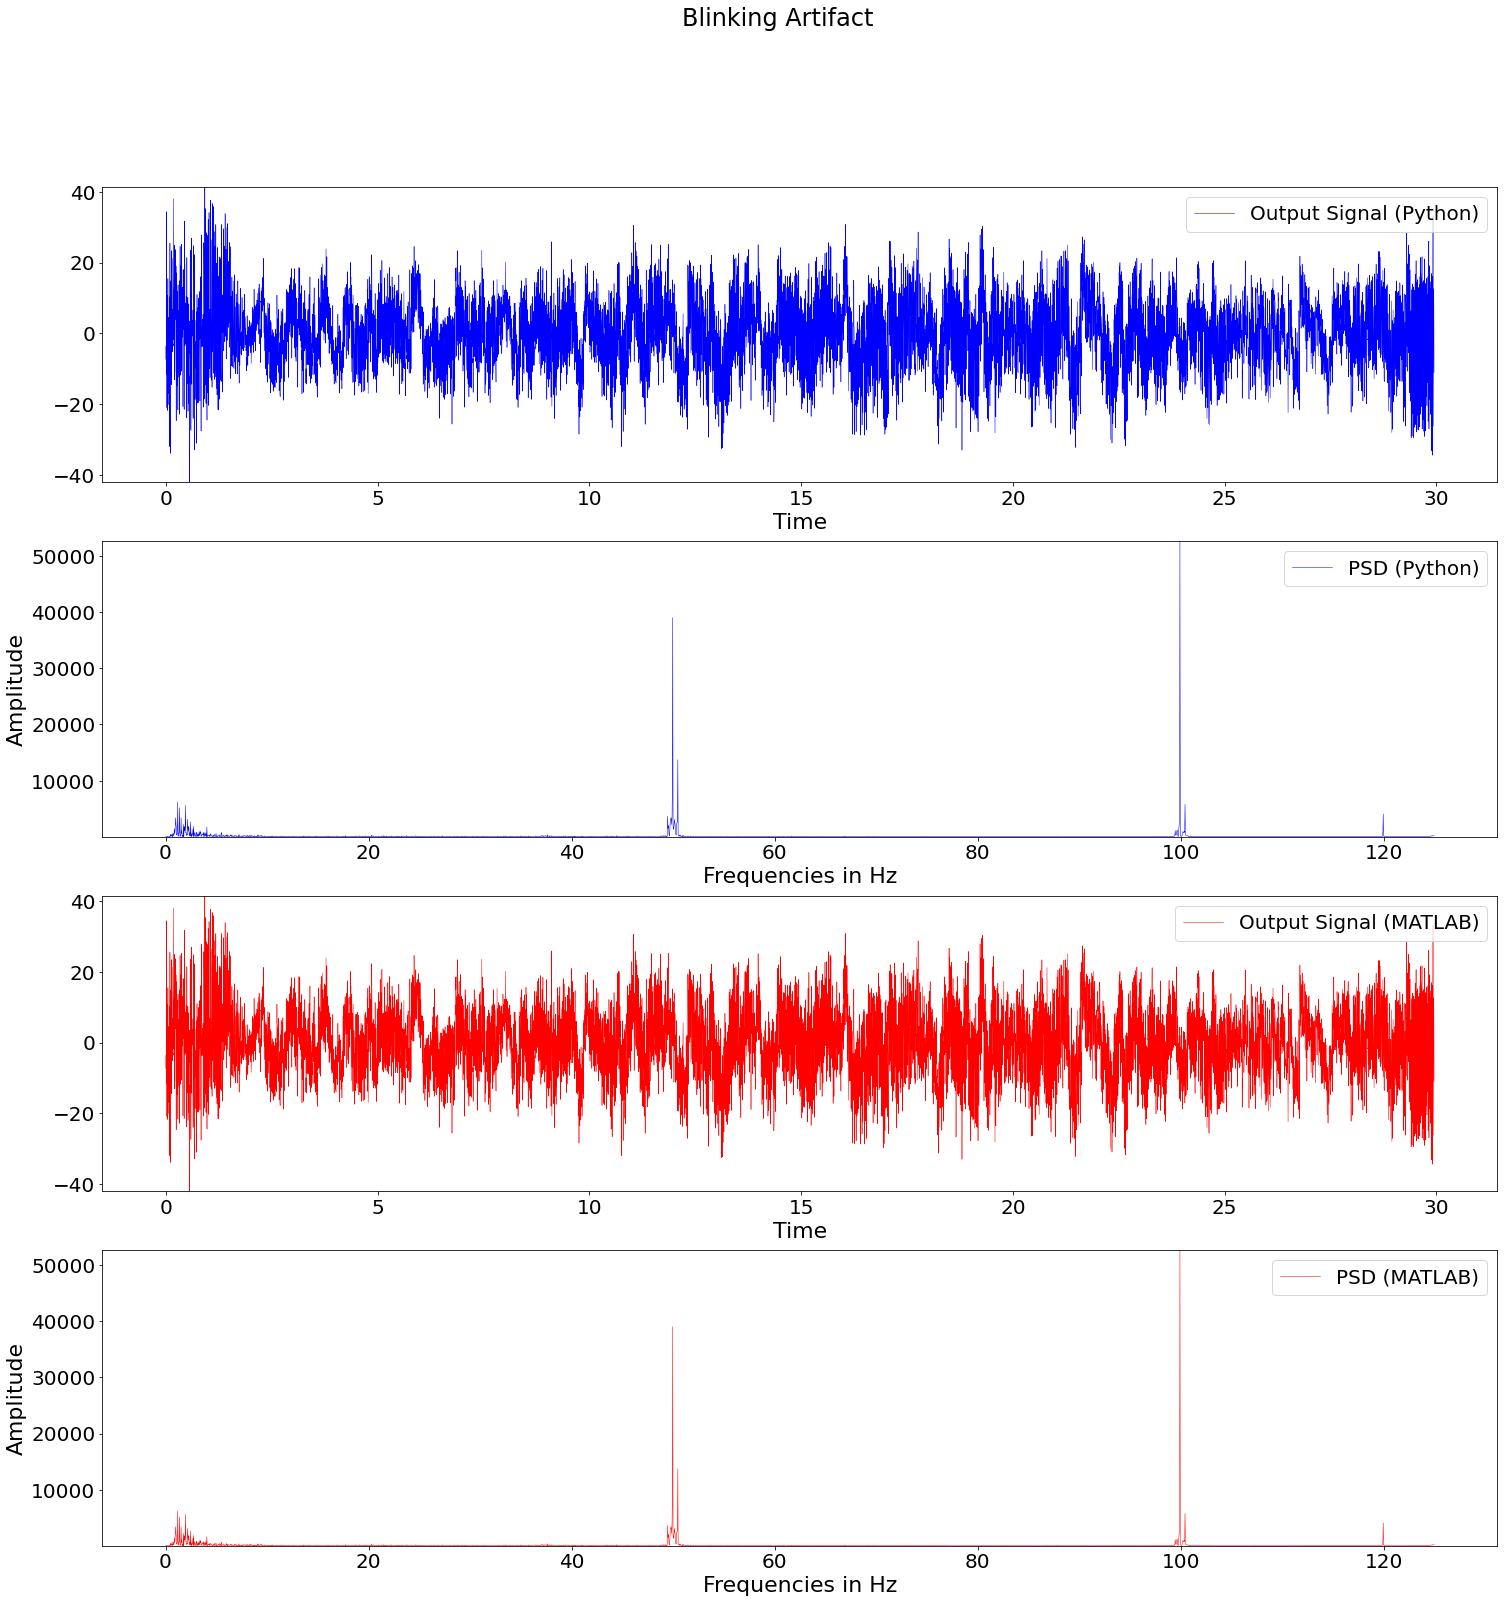

In [16]:
# Plotting both results
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Blinking Artifact', 
                        x_axes=[t_blink, freq_blink[idxs_half_blink], t_blink, freq_blink[idxs_half_blink]],
                        y_axes=[ExG_blink_bayes[1], np.abs(psd_blink_bayes[idxs_half_blink]), ExG_blink_bayes_m,np.abs(psd_blink_bayes_m[idxs_half_blink])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Output Signal (Python)', 'PSD (Python)', 'Output Signal (MATLAB)', 'PSD (MATLAB)'],
                        plot_colors=['b', 'b', 'r', 'r'])

#### (iii) Movement Artifact

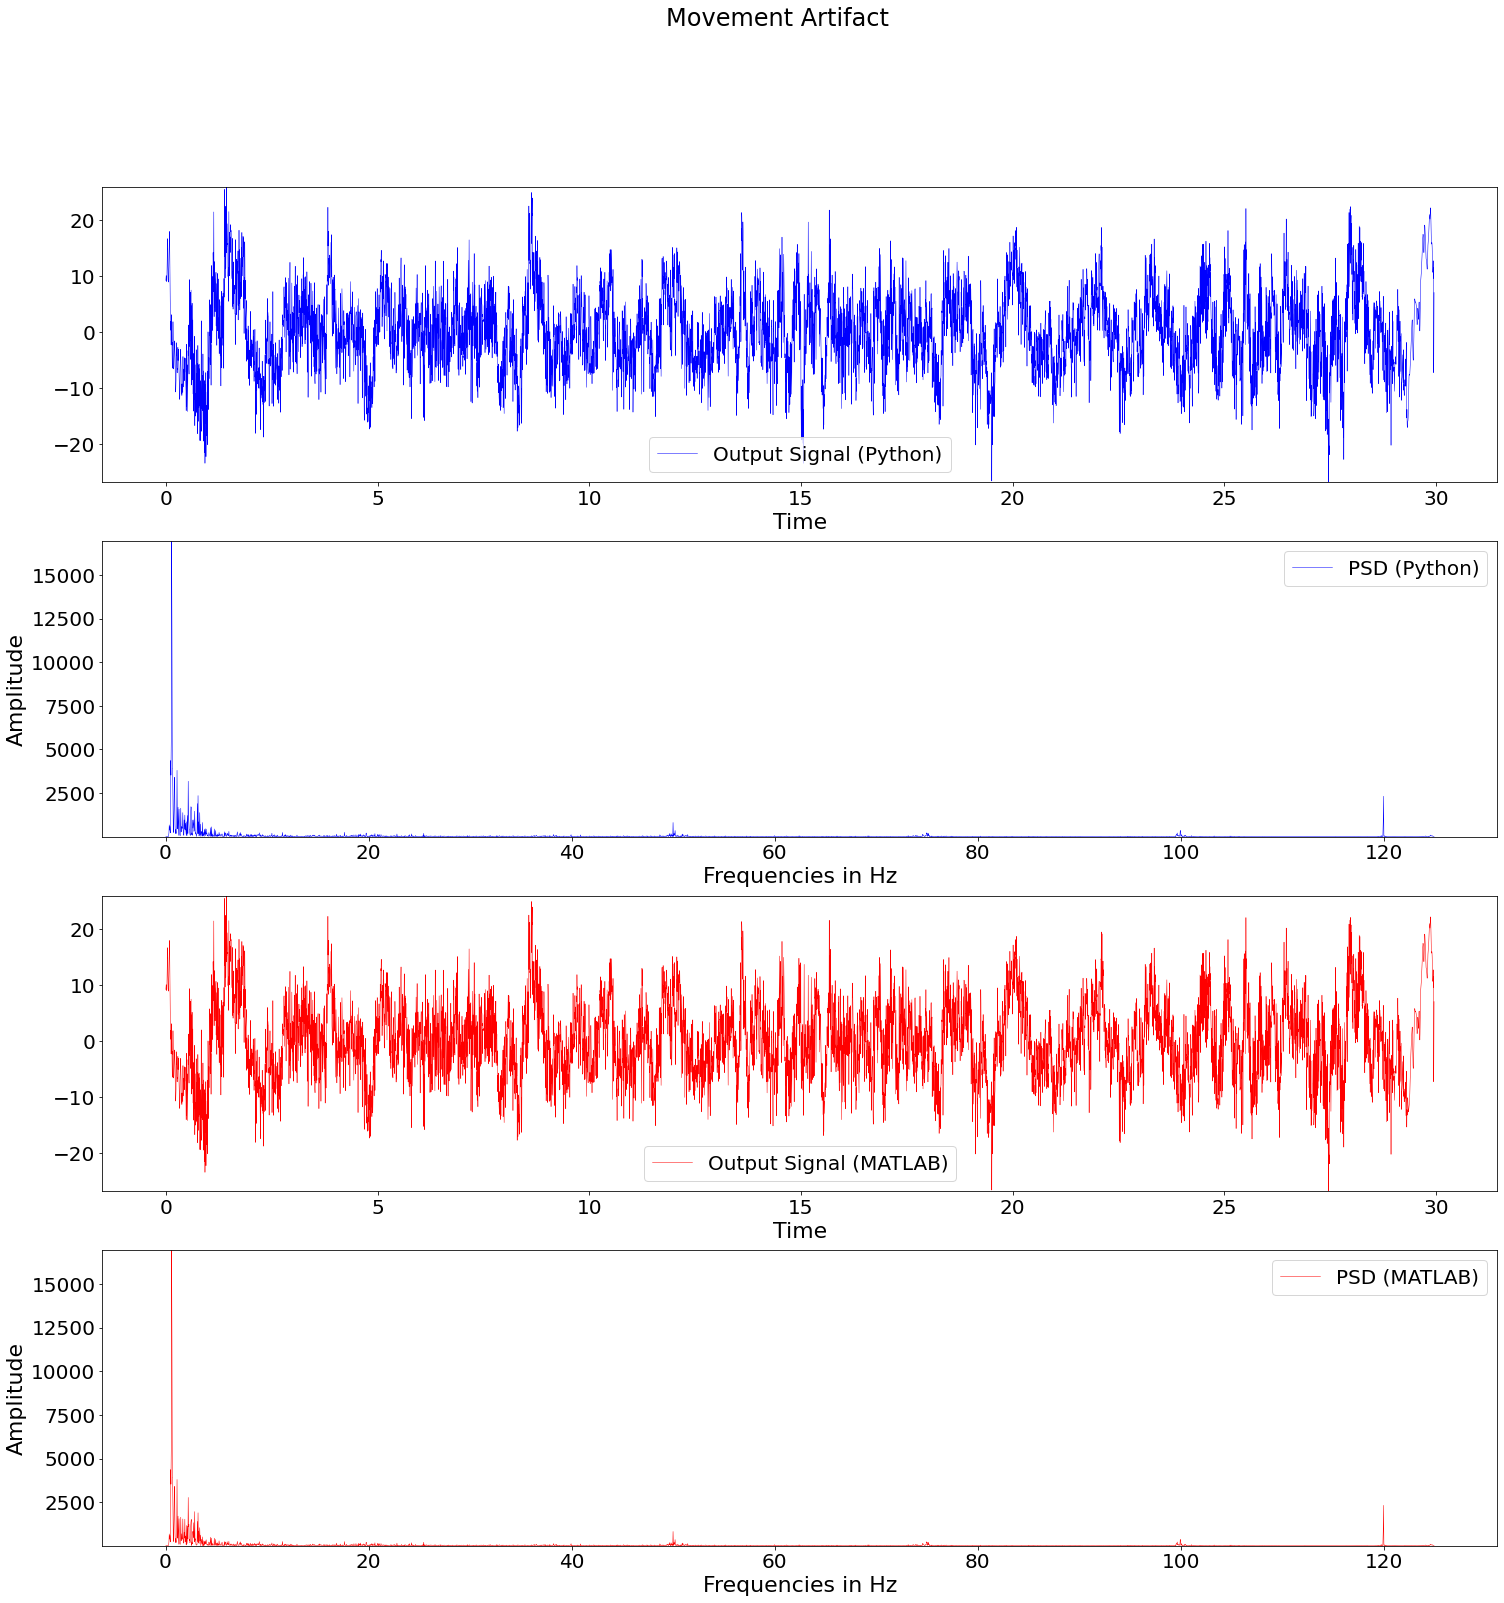

In [17]:
# Plotting both results
plt.rcParams['figure.figsize'] = [25, 25]
plotting.subplot(4, 1, 'Movement Artifact', 
                        x_axes=[t_mov, freq_mov[idxs_half_mov], t_mov, freq_mov[idxs_half_mov]],
                        y_axes=[ExG_mov_bayes[1], np.abs(psd_mov_bayes[idxs_half_mov]), ExG_mov_bayes_m,np.abs(psd_mov_bayes_m[idxs_half_mov])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Output Signal (Python)', 'PSD (Python)', 'Output Signal (MATLAB)', 'PSD (MATLAB)'],
                        plot_colors=['b', 'b', 'r', 'r'])

### Universal Thresholding

In [18]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Universal threshold
def get_level_thd(level_coef: np.array):
    """
    Calculates the threshold value for each wavelet level  

    Args:
        level_coef: a numpy array containing the coefficients for the current level
    Returns:
        level_thd   : a threshold value for the current level
    """
    level_median = np.median(np.abs(level_coef))
    n = len(level_coef)
    level_thd = (level_median/0.75) * np.sqrt(2*np.log(n))
    return level_thd



# 1. Wavelet transform
wavLvl = 8
coef = pywt.wavedecn(ExG_tap_lpf[1, :], 
                        wavelet='coif4', 
                        level=wavLvl,
                        axes=0)

# 2. Determining threshold values for each level
level_thds = []
for level in range(1, wavLvl+1, 1): 
    get_data = coef[level].get("d") 
    level_thd = get_level_thd(get_data)
    level_thds.append(level_thd)

# 3. Thresholding: hard thresholding
coef_artifacts = []
coef_artifacts.append(coef[0])
for level in range(1, wavLvl+1, 1):
    tmp = {"d":  pywt.threshold(coef[level].get("d"), 
                                level_thds[level-1],
                                mode='hard')}
    coef_artifacts.append(tmp)

# 4. Reconstruct data
artifacts = pywt.waverecn(coef_artifacts, 'coif4')

ExG_univ = ExG_tap_lpf[1, :] - artifacts[:ExG_tap_lpf.shape[1]]
#       Computing Fourier Transform
t = ExG_tap[0]
n = len(t)
fhat_univ = np.fft.fft(ExG_univ)
psd_univ = fhat_univ * np.conj(fhat_univ)/n


Normalized cross correlation: [0.9131976]


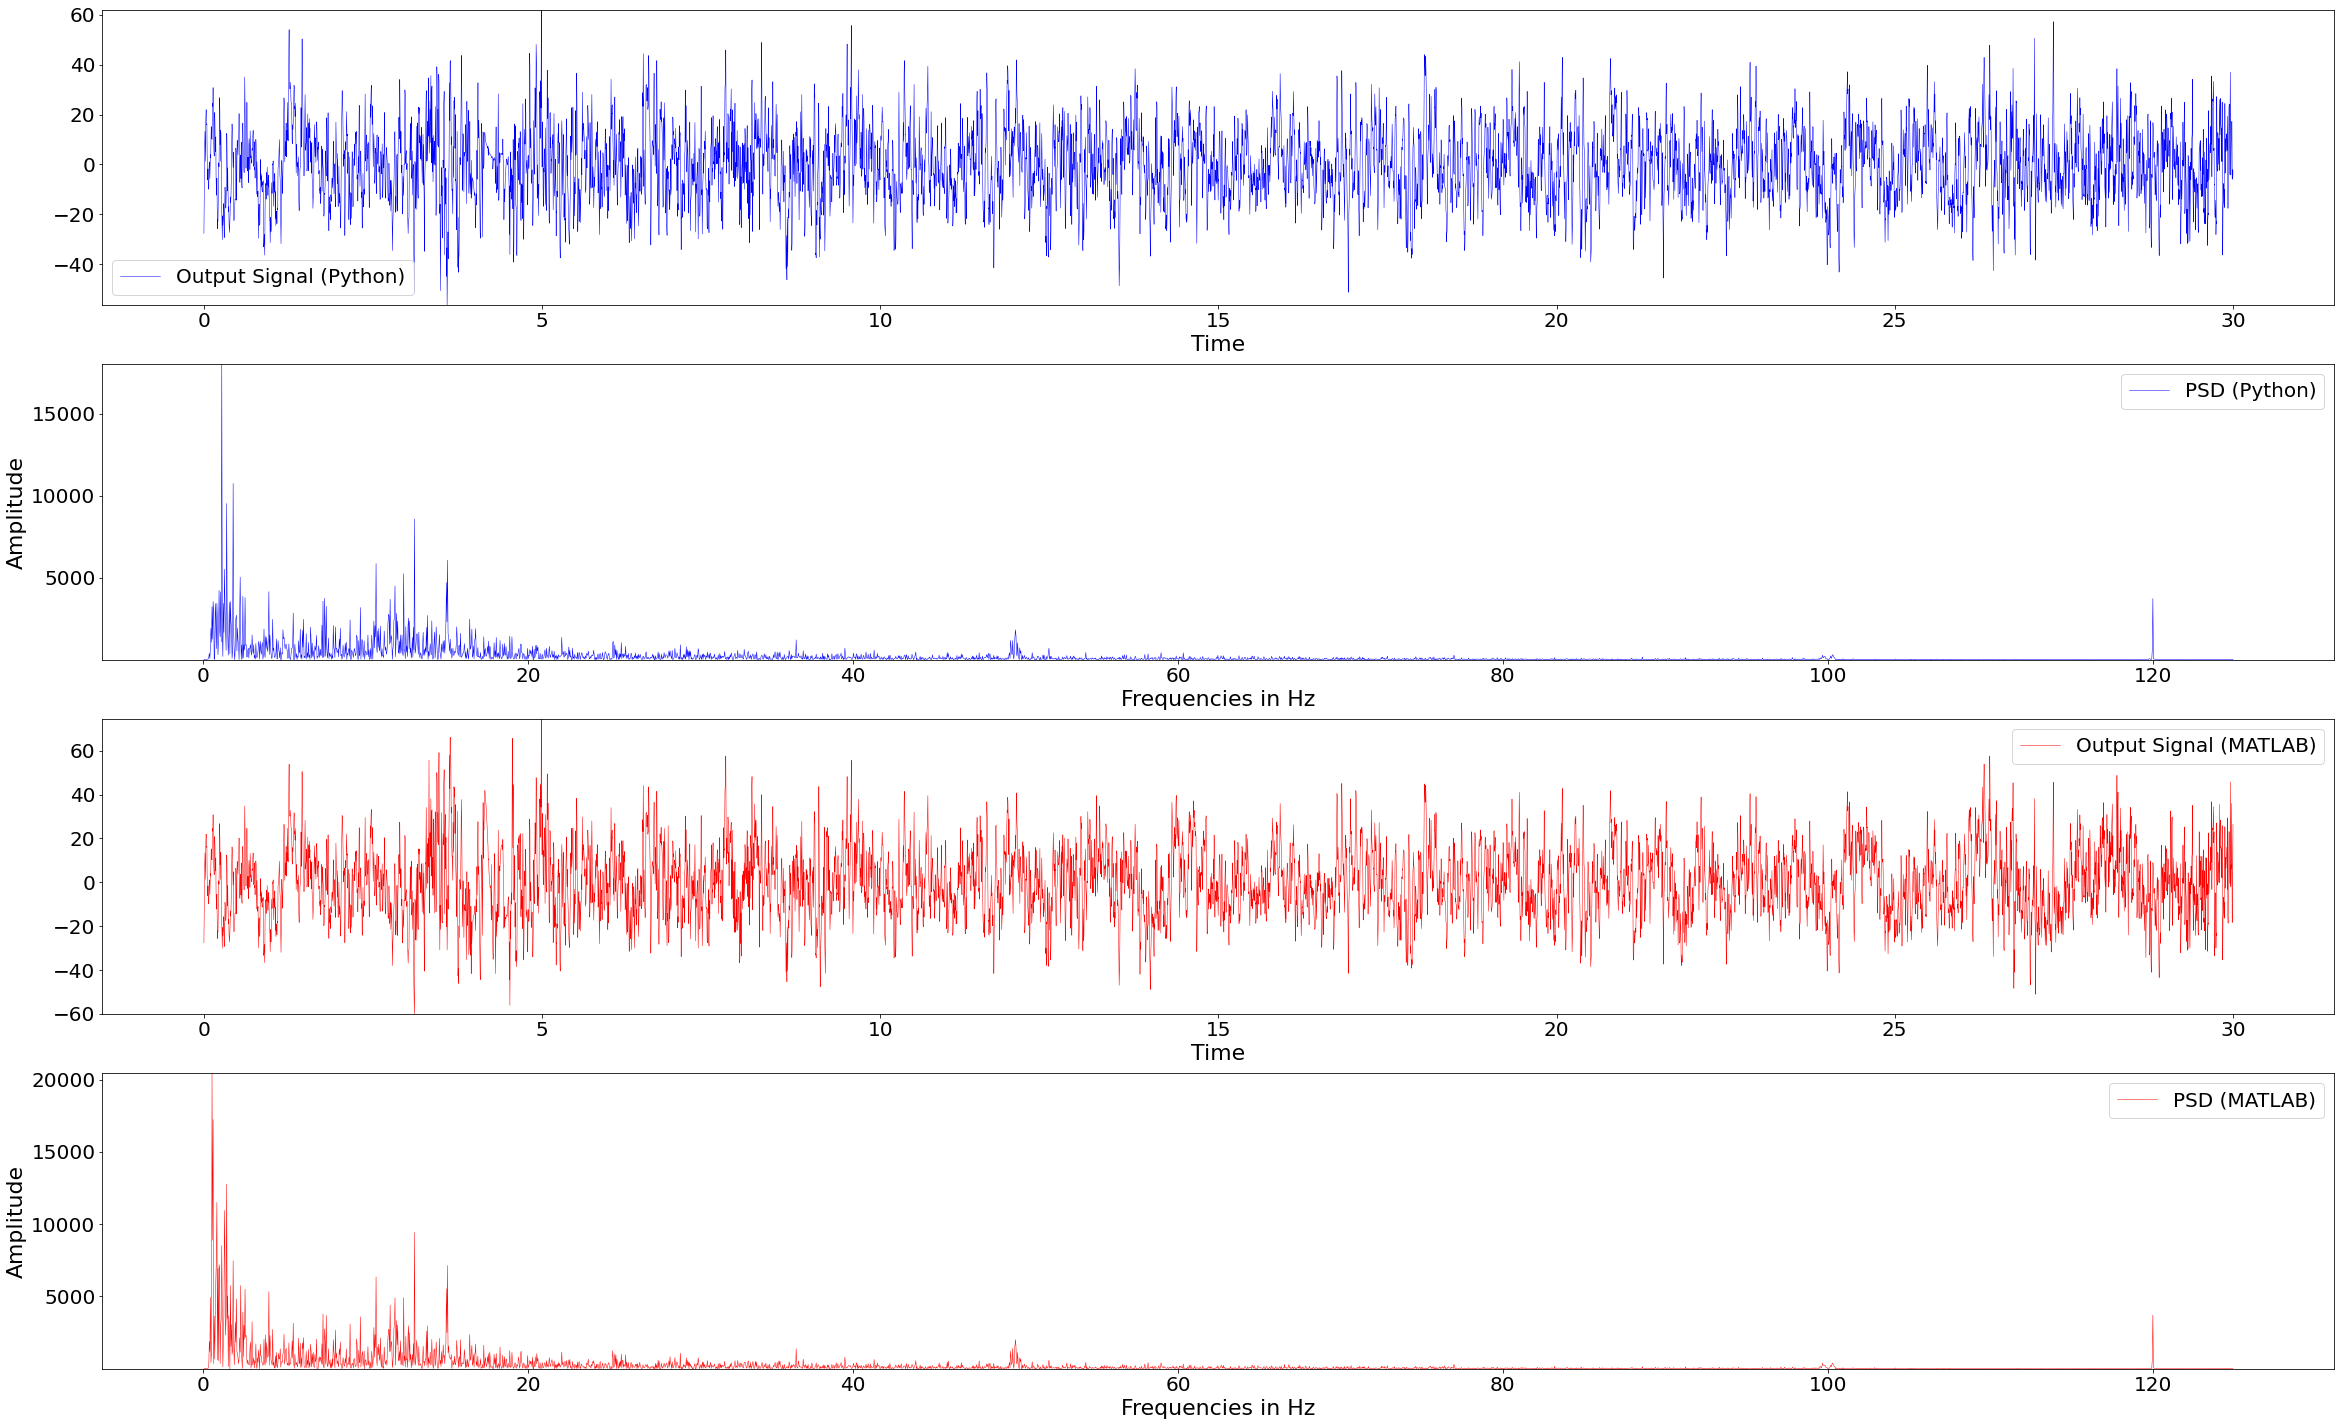

In [19]:
# Reading in results from MATLAB
ExG_univ_m = np.transpose( np.genfromtxt("ExG_data/ExG_univ_m.csv", delimiter = ',') )
#       Computing Fourier Transform
t = ExG_tap[0]
n = len(t)
fhat_univ_m = np.fft.fft(ExG_univ_m)
psd_univ_m = fhat_univ_m * np.conj(fhat_univ_m)/n

# Comparing both results by normalized cross correlation
ExG_univ_norm = (ExG_univ - np.mean(ExG_univ)) / (np.std(ExG_univ) * len(ExG_univ))
ExG_univ_m_norm = (ExG_univ_m - np.mean(ExG_univ_m)) / (np.std(ExG_univ_m))
c = np.correlate(ExG_univ_norm, ExG_univ_m_norm)
print("Normalized cross correlation:", c)

# Plotting both results
plt.rcParams['figure.figsize'] = [40, 25]
plotting.subplot(4, 1, None, 
                        x_axes=[t, freq_tap[idxs_half_tap], t, freq_tap[idxs_half_tap]],
                        y_axes=[ExG_univ, np.abs(psd_univ[idxs_half_tap]), ExG_univ_m,np.abs(psd_univ_m[idxs_half_tap])],
                        x_labels=['Time', 'Frequencies in Hz', 'Time', 'Frequencies in Hz'],
                        y_labels=[None , 'Amplitude', None, 'Amplitude'],
                        plot_labels=['Output Signal (Python)', 'PSD (Python)', 'Output Signal (MATLAB)', 'PSD (MATLAB)'],
                        plot_colors=['b', 'b', 'r', 'r'])

# B. Real time Noise Removal

Noise removal is applied in real time by:  
* Taking a batch of 528 data points (~2 seconds) from the stream, then  
* Applying the noise removal, and  
* Printing the result.  

After recording both the ExG data before noise removal (`exg_data_in`) and ExG data after noise removal (`exg_wav_thd`),  
the results of both Offline noise removal and Real time noise removal are compared.


Removed notch frequencies (Hz):
     50.00 :    2 windows
    100.00 :    2 windows
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33 samples (0.132 sec)

Normalized cross correlation (realtime vs. offline, in batches):
Batch 1 : 0.602901135329138
Batch 2 : 0.47531744110576524
Batch 3 : 0.4712154780732909
Normalized cross correlation (realtime vs. offline): 0.5481726012238087


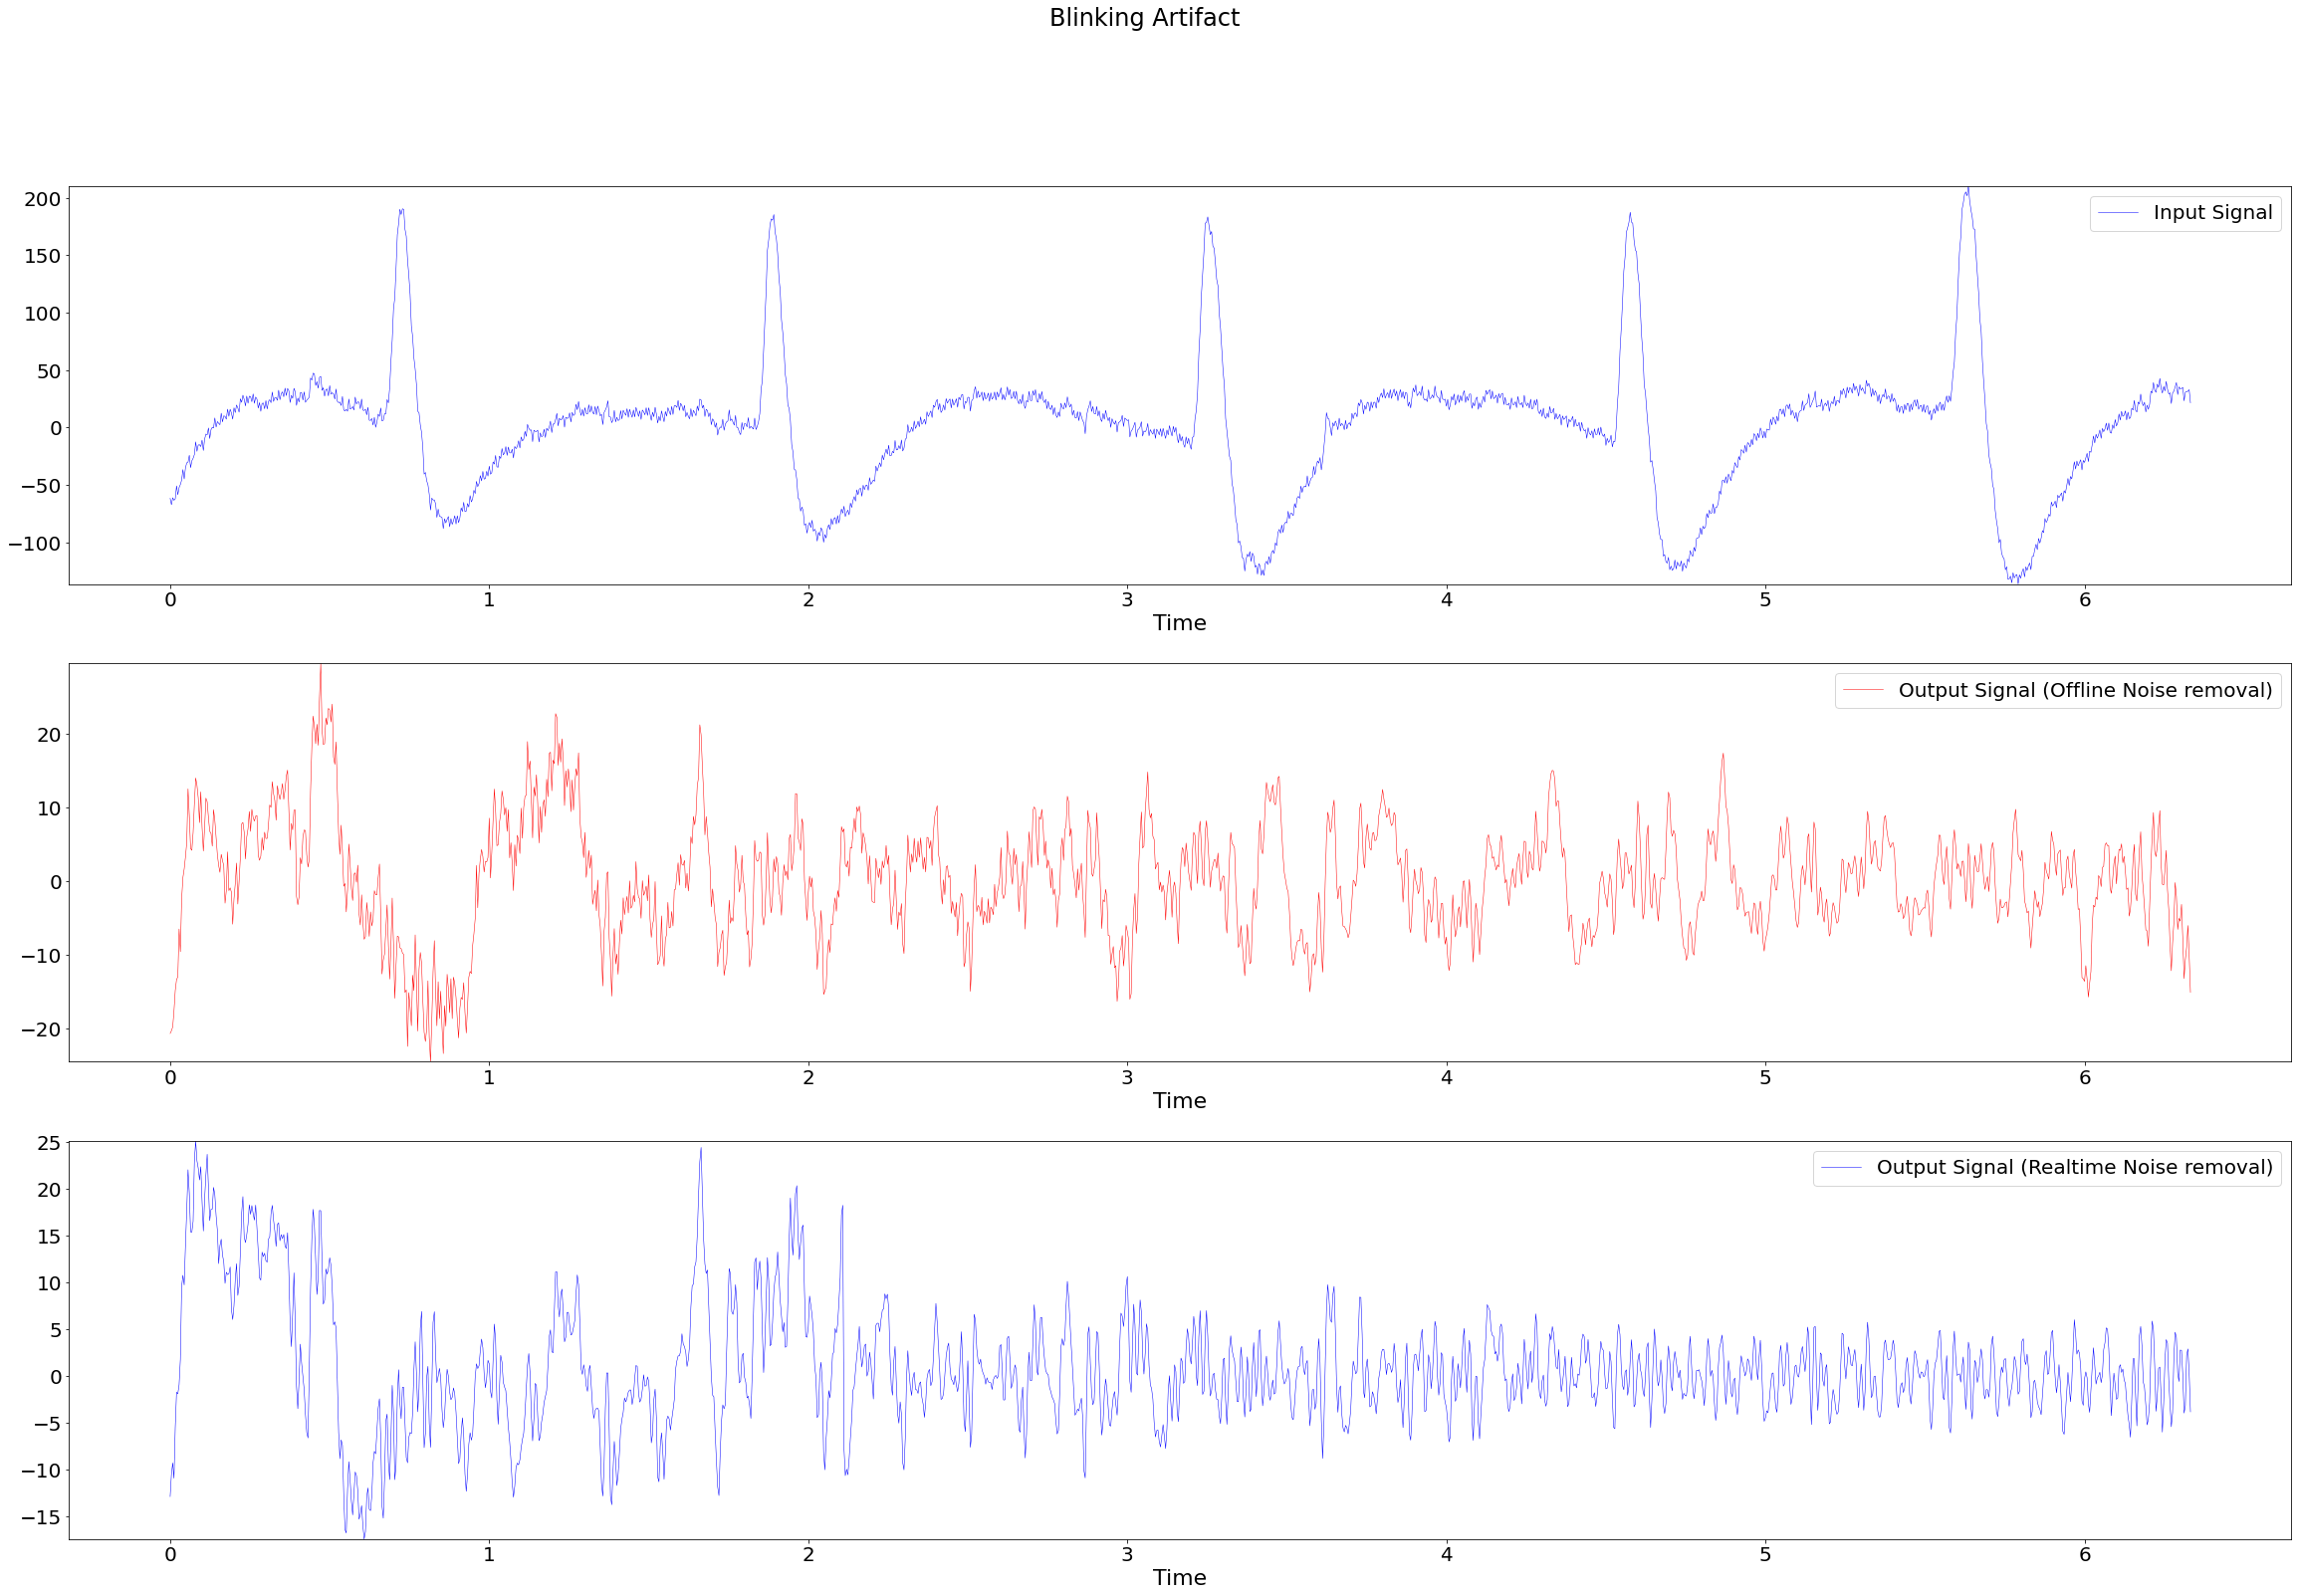

In [21]:
# a. Reading in our ExG signal
## i. Before Noise Removal
s_rate = 250
ln_freq = 50
exg_data_in = np.transpose( np.genfromtxt("ExG_data/exg_data_in_528blink.csv", delimiter = ',') )
t_array = np.arange(0, len(exg_data_in)/s_rate, 1/s_rate)

## ii. Noise removed
exg_wav_thd = np.transpose( np.genfromtxt("ExG_data/exg_wav_thd_528blink.csv", delimiter = ',') )
t_out = np.arange(0, len(exg_wav_thd)/s_rate, 1/s_rate)


# b. Applying Offline noise removal to original signal
exg_in_lnrm = ln_removal.clean_ln_ch(exg_data_in, ln_freq, s_rate)
exg_in_lpf = filtering.lp_filt_ch(exg_in_lnrm, s_rate)
artifacts = ebayesthd_wav_dwt(exg_in_lpf, s_rate=s_rate)
exg_in_wav_thd = exg_in_lpf - artifacts


# c. Comparing Offline noise removal and Real-time noise removal results
## i. Comparing both results by normalized cross correlation, done in batches
batch_size = 528
c_batches = np.array([])
exg_in_wav_thd_batch = np.array([])
for i in range(batch_size, len(exg_data_in)+1, batch_size):
    # Taking a batch
    exg_wavthd_batch = exg_wav_thd[i-batch_size : i-1]
    exg_in_wavthd_batch = exg_in_wav_thd[i-batch_size : i-1]
    # Calculating normalized cross correlation for a batch
    exg_wavthd_batch_norm = (exg_wavthd_batch - np.mean(exg_wavthd_batch)) / (np.std(exg_wavthd_batch) * len(exg_wavthd_batch))
    exg_in_wavthd_batch_norm = (exg_in_wavthd_batch - np.mean(exg_in_wavthd_batch)) / (np.std(exg_in_wavthd_batch))
    tmp = np.correlate(exg_wavthd_batch_norm, exg_in_wavthd_batch_norm)
    c_batches = np.append(c_batches, tmp)
print("Normalized cross correlation (realtime vs. offline, in batches):")
for i in range(0, len(c_batches)):
    print("Batch", i+1, ":", c_batches[i])

## ii. Comparing both results by normalized cross correlation, as a whole data
exg_wavthd_norm = (exg_wav_thd - np.mean(exg_wav_thd)) / (np.std(exg_wav_thd) * len(exg_wav_thd))
exg_in_wavthd_norm = (exg_in_wav_thd - np.mean(exg_in_wav_thd)) / (np.std(exg_in_wav_thd))
c = np.correlate(exg_wavthd_norm, exg_in_wavthd_norm)
print("Normalized cross correlation (realtime vs. offline):", np.max(c))


# Plotting the input and results
plt.rcParams['figure.figsize'] = [40, 25]
plotting.subplot(3, 1, 'Blinking Artifact', 
                        x_axes=[t_array, t_array, t_out],
                        y_axes=[exg_data_in, exg_in_wav_thd, exg_wav_thd],
                        x_labels=['Time', 'Time', 'Time'],
                        y_labels=[None, None, None],
                        plot_labels=['Input Signal', 'Output Signal (Offline Noise removal)', 'Output Signal (Realtime Noise removal)'],
                        plot_colors=['b', 'r', 'b'])
